Reading data...
Successfully loaded data with 287829 rows and 48 columns
Dropping variables with many NAs...
Filtering data for years 2010-2015...
Years in data:
year
2010    26784
2011    28222
2012    28469
2013    28474
2014    28151
2015    27506
Name: count, dtype: int64
Adding missing year-company combinations...
Generating status_alive...
Creating sales metrics...
Calculating sales growth...
Creating age variable...
Creating fast growth target with new definition...
Number of firms with data in both 2012 and 2014: 17927
Number of fast-growing firms: 3885.0
Percentage of fast-growing firms: 22.60%

Breakdown of criteria for fast-growing firms:
Employee growth condition met: 7.13%
Profit growth condition met: 80.98%
Fixed assets growth condition met: 44.63%


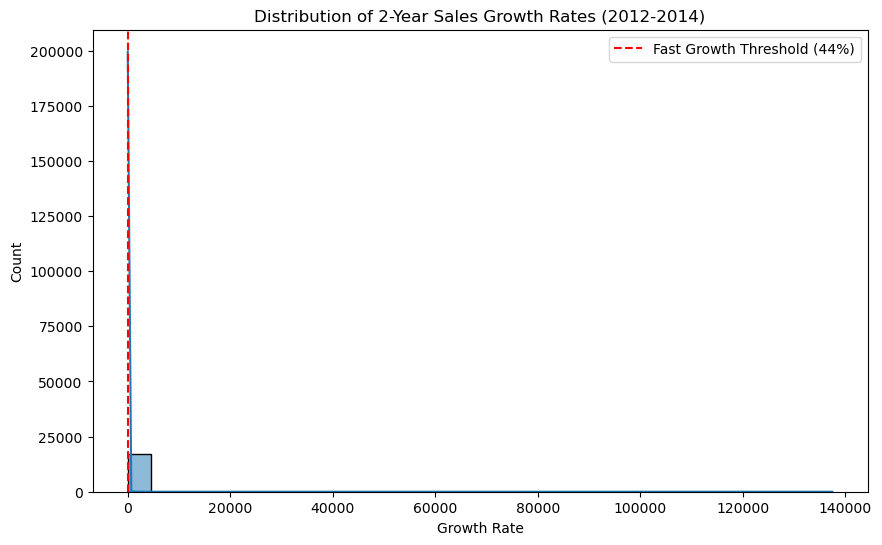

Created visualization of growth distribution


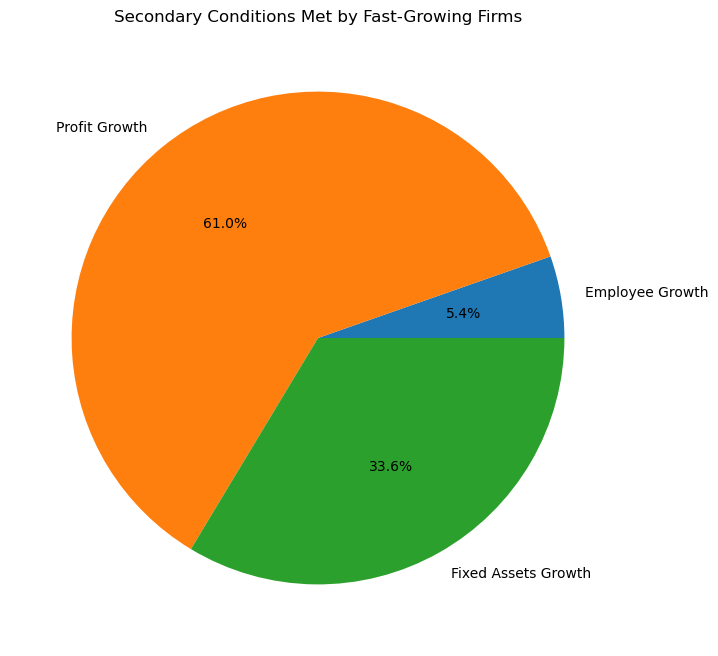

Created visualization of secondary conditions met
Creating sample for modeling...
Final sample size: 21723 firms
Feature engineering...
Industry distribution:
industry_group
Services         15372
Manufacturing     6351
Name: count, dtype: int64

# Exploratory Analysis for Fast Growth Prediction
## Running OLS regressions to understand relationships between variables

OLS Regression: Effect of Firm Size on Fast Growth
                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     160.6
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           8.15e-70
Time:                        16:43:09   Log-Likelihood:                -8777.3
No. Observations:               16619   AIC:                         1.756e+04
Df Residuals:            

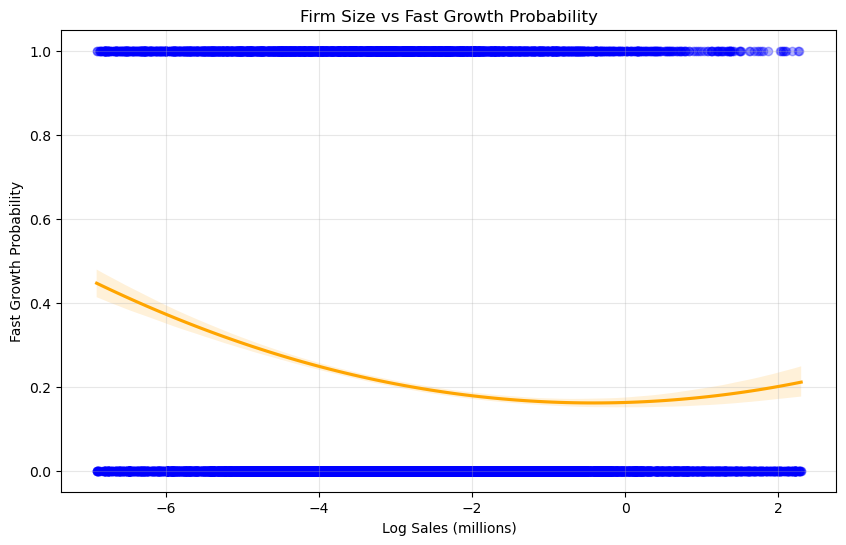


Created visualization of firm size vs fast growth


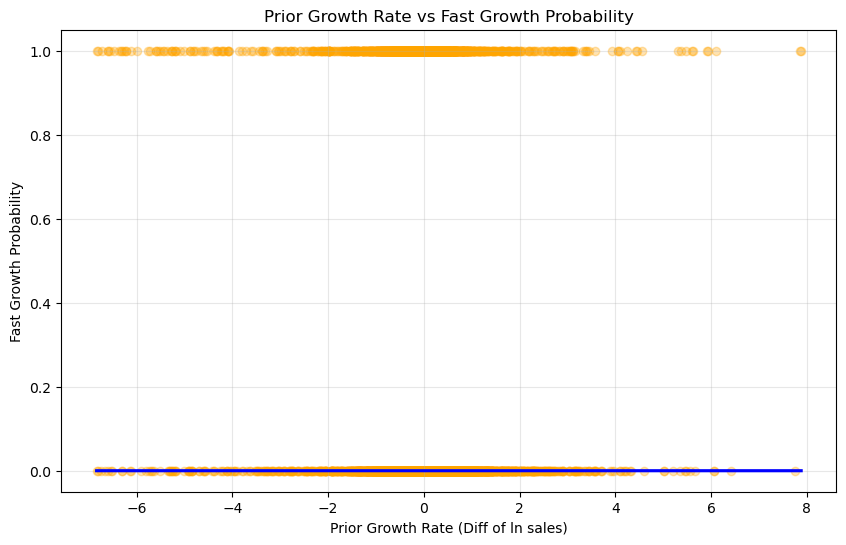

Created visualization of prior growth vs fast growth


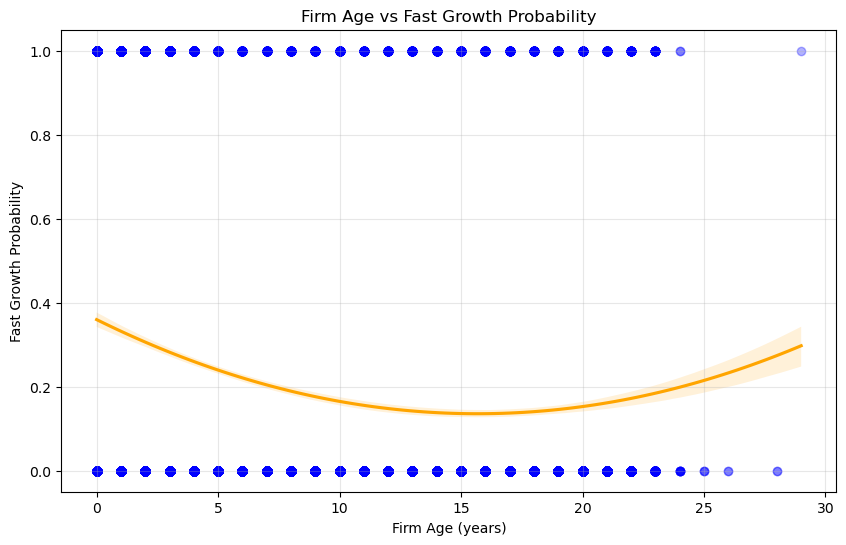

Created visualization of firm age vs fast growth


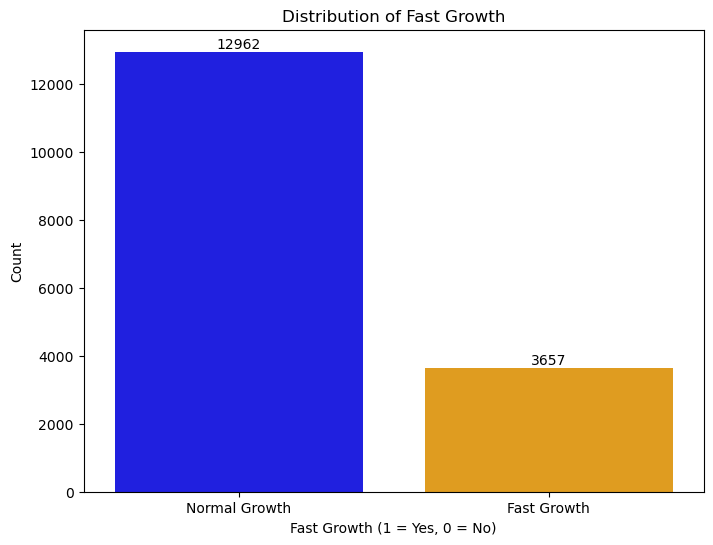

Created fast growth distribution bar chart


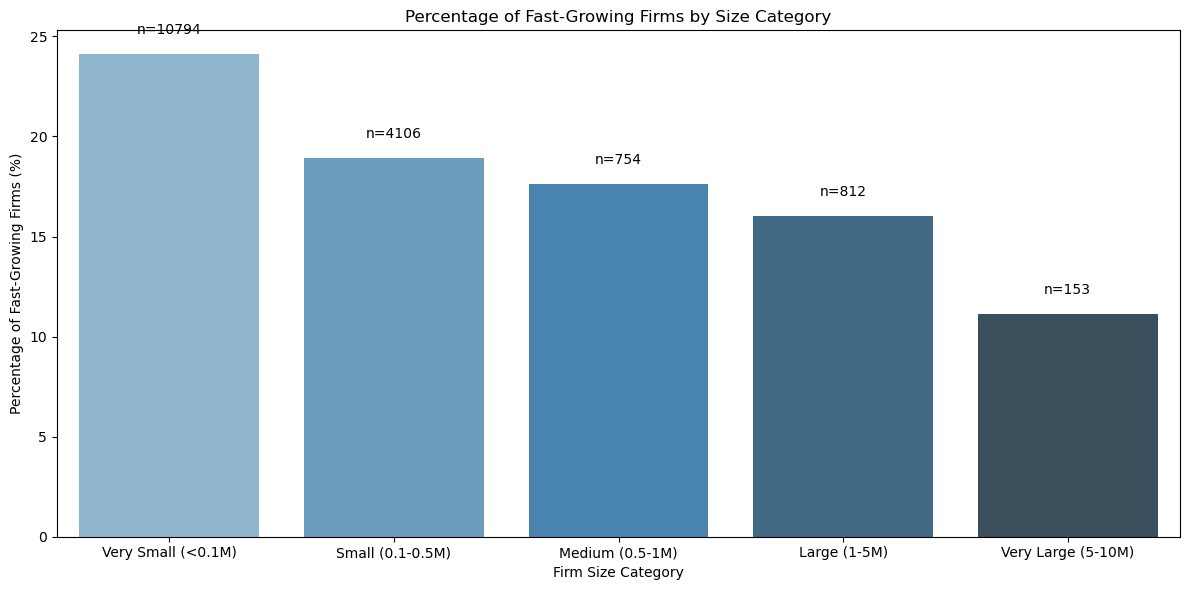

Created firm size analysis plot


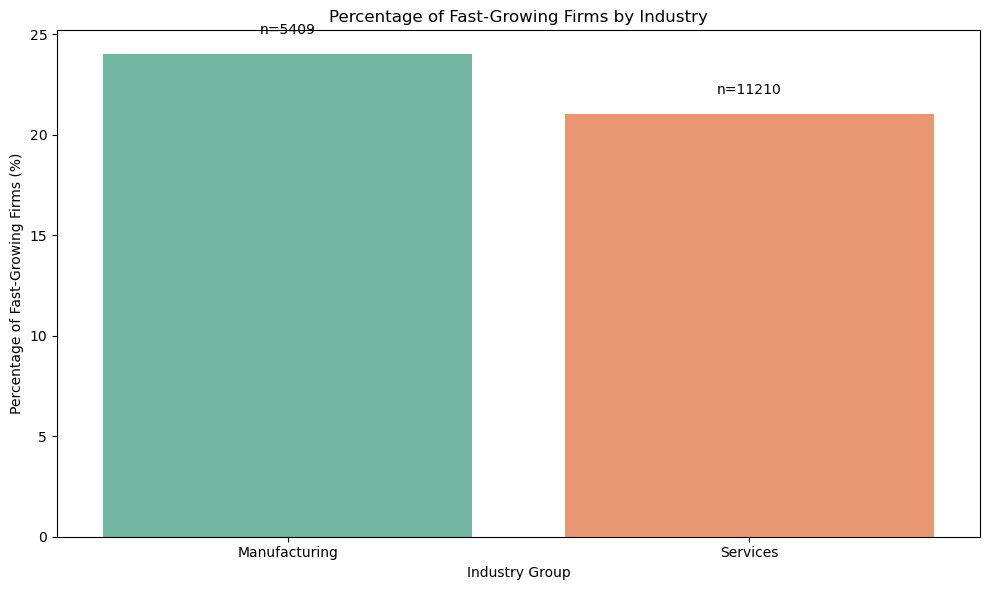

Created industry analysis plot
Saving prepared data to ./fast_growth_firms_clean.csv

Fast Growth Distribution:
   fast_growth  comp_id  percentage
0          0.0    12962   77.995066
1          1.0     3657   22.004934

Detailed analysis of growth criteria:
Sales growth ≥44%: 29.71%
Employee growth ≥21% with personnel costs ≤32%: 6.79%
Profit growth ≥32% or turned positive: 42.52%
Fixed assets growth ≥21%: 25.63%

Finished data preparation. Ready for modeling!


In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Set up paths
# You will need to adjust these paths to match your environment
# Current script folder
path = os.getcwd()

# Define input and output paths
data_in = "."  # assuming the data is in the current directory
data_out = "."

# Import data
print("Reading data...")
csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

try:
    data = pd.read_csv(csv_path)
    print(f"Successfully loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {csv_path}")
    # Alternative approach if file not found locally
    print("Attempting to load from alternative source...")
    # You might want to add alternative loading logic here

# Drop variables with many NAs
print("Dropping variables with many NAs...")
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

# Filter data for the years we're interested in
print("Filtering data for years 2010-2015...")
data = data.query("year >= 2010 & year <= 2015")

# Check years in data
print("Years in data:")
print(data['year'].value_counts().sort_index())

# Add all missing year and comp_id combinations
print("Adding missing year-company combinations...")
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way to define it as NaN

# Generate status_alive; if sales larger than zero and not-NA, then firm is alive
print("Generating status_alive...")
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# Create sales metrics
print("Creating sales metrics...")
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # handle negative sales
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

# Add squared terms
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

# Calculate year-over-year growth
print("Calculating sales growth...")
data["sales_mil_log_lag1"] = data.groupby("comp_id")["sales_mil_log"].shift(1)
data["sales_mil_log_lag2"] = data.groupby("comp_id")["sales_mil_log"].shift(2)
data["growth_1y"] = data["sales_mil_log"] - data["sales_mil_log_lag1"]
data["growth_2y"] = data["sales_mil_log"] - data["sales_mil_log_lag2"]
data["growth_1y_sq"] = data["growth_1y"] ** 2

# Create age variable
print("Creating age variable...")
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["age2"] = data["age"] ** 2

data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# Replace growth for new firms with 0
data["growth_1y"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["growth_1y"])
)
data["growth_2y"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["growth_2y"])
)

# Define fast growth target based on specific criteria
print("Creating fast growth target with new definition...")
# First filter to only firms with data in both 2012 and 2014
firms_2012 = data.query("year == 2012 & status_alive == 1")[
    ["comp_id", "sales", "profit_loss_year", "fixed_assets", "personnel_exp", "labor_avg"]
].copy()
firms_2012.rename(
    columns={
        "sales": "sales_2012",
        "profit_loss_year": "profit_2012", 
        "fixed_assets": "fixed_assets_2012",
        "personnel_exp": "personnel_exp_2012",
        "labor_avg": "labor_avg_2012"
    }, 
    inplace=True
)

firms_2014 = data.query("year == 2014 & status_alive == 1")[
    ["comp_id", "sales", "profit_loss_year", "fixed_assets", "personnel_exp", "labor_avg"]
].copy()
firms_2014.rename(
    columns={
        "sales": "sales_2014",
        "profit_loss_year": "profit_2014", 
        "fixed_assets": "fixed_assets_2014",
        "personnel_exp": "personnel_exp_2014",
        "labor_avg": "labor_avg_2014"
    }, 
    inplace=True
)

# Merge 2012 and 2014 data
growth_data = firms_2012.merge(firms_2014, on="comp_id", how="inner")
print(f"Number of firms with data in both 2012 and 2014: {len(growth_data)}")

# Calculate growth metrics
# Handle various edge cases with zero or negative values
growth_data["sales_growth"] = np.where(
    (growth_data["sales_2012"] > 0) & (growth_data["sales_2014"] > 0),
    (growth_data["sales_2014"] / growth_data["sales_2012"]) - 1,
    np.nan
)

growth_data["fixed_assets_growth"] = np.where(
    (growth_data["fixed_assets_2012"] > 0) & (growth_data["fixed_assets_2014"] > 0),
    (growth_data["fixed_assets_2014"] / growth_data["fixed_assets_2012"]) - 1,
    np.nan
)

growth_data["personnel_exp_growth"] = np.where(
    (growth_data["personnel_exp_2012"] > 0) & (growth_data["personnel_exp_2014"] > 0),
    (growth_data["personnel_exp_2014"] / growth_data["personnel_exp_2012"]) - 1,
    np.nan
)

# Handle labor average (employee count) growth - handle missing/zero values
growth_data["labor_avg_growth"] = np.where(
    (growth_data["labor_avg_2012"] > 0) & (growth_data["labor_avg_2014"] > 0),
    (growth_data["labor_avg_2014"] / growth_data["labor_avg_2012"]) - 1,
    np.nan
)

# Handle profit growth - need special handling for negative or zero values
growth_data["profit_growth"] = np.where(
    (growth_data["profit_2012"] > 0) & (growth_data["profit_2014"] > 0),
    (growth_data["profit_2014"] / growth_data["profit_2012"]) - 1,
    np.nan
)

# Flag for profit turning from negative to positive
growth_data["profit_turned_positive"] = np.where(
    (growth_data["profit_2012"] <= 0) & (growth_data["profit_2014"] > 0),
    1, 0
)

# Apply the fast growth definition
# 1. Revenue increased by at least 44% over two years
growth_data["high_sales_growth"] = (growth_data["sales_growth"] >= 0.44).astype(int)

# 2a. Employee count grew by ≥21%, with personnel costs growth ≤32%
growth_data["employee_growth_condition"] = (
    (growth_data["labor_avg_growth"] >= 0.21) & 
    (growth_data["personnel_exp_growth"] <= 0.32)
).astype(int)

# 2b. Profit increased by ≥32%, or turned from negative to positive
growth_data["profit_growth_condition"] = (
    (growth_data["profit_growth"] >= 0.32) | 
    (growth_data["profit_turned_positive"] == 1)
).astype(int)

# 2c. Fixed assets grew by ≥21%
growth_data["fixed_assets_growth_condition"] = (
    growth_data["fixed_assets_growth"] >= 0.21
).astype(int)

# Final fast growth indicator: Sales growth >= 44% AND at least one of the other conditions
growth_data["meets_secondary_condition"] = np.where(
    (growth_data["employee_growth_condition"] == 1) |
    (growth_data["profit_growth_condition"] == 1) |
    (growth_data["fixed_assets_growth_condition"] == 1),
    1, 0
)

growth_data["fast_growth"] = np.where(
    (growth_data["high_sales_growth"] == 1) & 
    (growth_data["meets_secondary_condition"] == 1),
    1, 0
)

# Handle NAs - if we can't calculate any of these, we should set fast_growth to NA
growth_data["fast_growth"] = np.where(
    (growth_data["sales_growth"].isna()) |
    (
        (growth_data["labor_avg_growth"].isna()) &
        (growth_data["profit_growth"].isna()) & 
        (growth_data["profit_turned_positive"] == 0) &
        (growth_data["fixed_assets_growth"].isna())
    ),
    np.nan, 
    growth_data["fast_growth"]
)

# Clean up NaNs for final version
growth_data = growth_data.dropna(subset=["fast_growth"])

print(f"Number of fast-growing firms: {growth_data['fast_growth'].sum()}")
print(f"Percentage of fast-growing firms: {growth_data['fast_growth'].mean() * 100:.2f}%")

# Get breakdown of which criteria were met
print("\nBreakdown of criteria for fast-growing firms:")
fast_growing = growth_data[growth_data["fast_growth"] == 1]
print(f"Employee growth condition met: {fast_growing['employee_growth_condition'].mean() * 100:.2f}%")
print(f"Profit growth condition met: {fast_growing['profit_growth_condition'].mean() * 100:.2f}%")
print(f"Fixed assets growth condition met: {fast_growing['fixed_assets_growth_condition'].mean() * 100:.2f}%")

# Create visualization of growth distribution
plt.figure(figsize=(10, 6))
sns.histplot(growth_data["sales_growth"], bins=30, kde=True)
plt.axvline(x=0.44, color='red', linestyle='--', 
            label=f'Fast Growth Threshold (44%)')
plt.title('Distribution of 2-Year Sales Growth Rates (2012-2014)')
plt.xlabel('Growth Rate')
plt.ylabel('Count')
plt.legend()
plt.savefig('growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
print("Created visualization of growth distribution")

# Create a pie chart showing the breakdown of conditions met
condition_counts = {
    "Employee Growth": fast_growing['employee_growth_condition'].sum(),
    "Profit Growth": fast_growing['profit_growth_condition'].sum(),
    "Fixed Assets Growth": fast_growing['fixed_assets_growth_condition'].sum()
}

plt.figure(figsize=(8, 8))
plt.pie(condition_counts.values(), labels=condition_counts.keys(), autopct='%1.1f%%')
plt.title('Secondary Conditions Met by Fast-Growing Firms')
plt.savefig('fast_growth_conditions.png', dpi=300, bbox_inches="tight")
plt.show()
print("Created visualization of secondary conditions met")

# Keep only the essential columns for the main dataset
growth_data_simplified = growth_data[["comp_id", "fast_growth"]]

# Merge the fast growth indicator back to the main data
data = data.merge(growth_data_simplified, on="comp_id", how="left")

# Sample design - focus on firms in 2012
print("Creating sample for modeling...")
model_data = data.query("year == 2012 & status_alive == 1").copy()

# Look at firms below 10m euro revenues and above 1000 euros
model_data = model_data.query("sales_mil <= 10 & sales_mil >= 0.001")
print(f"Final sample size: {model_data.shape[0]} firms")

# Feature engineering
print("Feature engineering...")

# Change some industry category codes
model_data["ind2_cat"] = model_data["ind2"].copy()
model_data["ind2_cat"] = np.where(model_data["ind2"] > 56, 60, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(model_data["ind2"] < 26, 20, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(
    (model_data["ind2"] < 55) & (model_data["ind2"] > 35), 40, model_data["ind2_cat"]
)
model_data["ind2_cat"] = np.where(model_data["ind2"] == 31, 30, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(model_data["ind2"].isna(), 99, model_data["ind2_cat"])

# Industry groups - manufacturing and services
# Manufacturing: ind2 < 45, Services: ind2 >= 45
model_data["industry_group"] = np.where(model_data["ind2"] < 45, "Manufacturing", "Services")
print("Industry distribution:")
print(model_data["industry_group"].value_counts())

# Firm characteristics
model_data["foreign_management"] = np.where(
    model_data["foreign"] >= 0.5, 1, np.where(model_data["foreign"].isna(), np.nan, 0)
)
model_data["gender_m"] = model_data["gender"].astype("category")
model_data["m_region_loc"] = model_data["region_m"].astype("category")

# CEO age
model_data["ceo_age"] = model_data["year"] - model_data["birth_year"]
model_data["ceo_age"] = np.where(model_data["ceo_age"] < 25, 25, model_data["ceo_age"])
model_data["ceo_age"] = np.where(model_data["ceo_age"] > 75, 75, model_data["ceo_age"])
model_data["ceo_age"] = np.where(
    model_data["ceo_age"].isna(), model_data["ceo_age"].mean(), model_data["ceo_age"]
)
model_data["ceo_young"] = (model_data["ceo_age"] < 40).astype(int)

# Create category type variables
model_data["urban_m"] = model_data["urban_m"].astype("category")
model_data["ind2_cat"] = model_data["ind2_cat"].astype("category")
model_data["fast_growth_f"] = model_data["fast_growth"].astype("category")
model_data["fast_growth_f"] = model_data["fast_growth_f"].cat.rename_categories(["normal_growth", "fast_growth"])

# OLS regression analysis
print("\n# Exploratory Analysis for Fast Growth Prediction")
print("## Running OLS regressions to understand relationships between variables\n")

# Size effect on fast growth
try:
    ols_sales = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=model_data).fit()
    print("OLS Regression: Effect of Firm Size on Fast Growth")
    print(ols_sales.summary())
except Exception as e:
    print(f"Could not run size OLS regression: {e}")

# Growth effect on future fast growth
try:
    ols_growth = smf.ols("fast_growth ~ growth_1y + growth_1y_sq", data=model_data).fit()
    print("\nOLS Regression: Effect of Prior Growth on Fast Growth")
    print(ols_growth.summary())
except Exception as e:
    print(f"Could not run growth OLS regression: {e}")

# Age effect on fast growth
try:
    ols_age = smf.ols("fast_growth ~ age + age2", data=model_data).fit()
    print("\nOLS Regression: Effect of Firm Age on Fast Growth")
    print(ols_age.summary())
except Exception as e:
    print(f"Could not run age OLS regression: {e}")

# Create key visualizations
try:
    # 1. Size vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="sales_mil_log", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'blue'}, 
                line_kws={'color':'orange'},
                order=2)
    plt.title('Firm Size vs Fast Growth Probability')
    plt.xlabel('Log Sales (millions)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("size_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("\nCreated visualization of firm size vs fast growth")
    
    # 2. Prior Growth vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="growth_1y", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'orange'}, 
                line_kws={'color':'blue'},
                lowess=True)
    plt.title('Prior Growth Rate vs Fast Growth Probability')
    plt.xlabel('Prior Growth Rate (Diff of ln sales)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("prior_growth_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Created visualization of prior growth vs fast growth")
    
    # 3. Age vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="age", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'blue'}, 
                line_kws={'color':'orange'},
                order=2)
    plt.title('Firm Age vs Fast Growth Probability')
    plt.xlabel('Firm Age (years)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("age_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Created visualization of firm age vs fast growth")
    
    # 4. Fast Growth Distribution
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x="fast_growth", data=model_data, palette=['blue', 'orange'])
    # Add count labels on top of each bar
    for i in ax.containers:
        ax.bar_label(i)
    plt.title('Distribution of Fast Growth')
    plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
    plt.savefig("fast_growth_distribution_bar.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Created fast growth distribution bar chart")
    
    # 5. Firm Size Category Analysis
    model_data['size_category'] = pd.cut(
        model_data['sales_mil'],
        bins=[0, 0.1, 0.5, 1, 5, 10],
        labels=['Very Small (<0.1M)', 'Small (0.1-0.5M)', 'Medium (0.5-1M)', 'Large (1-5M)', 'Very Large (5-10M)']
    )
    
    size_growth = model_data.groupby('size_category')['fast_growth'].agg(['mean', 'count']).reset_index()
    size_growth['mean'] = size_growth['mean'] * 100  # Convert to percentage
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='size_category', y='mean', data=size_growth, palette='Blues_d')
    
    # Add count labels on top of each bar
    for i, row in enumerate(size_growth.itertuples()):
        ax.text(i, row.mean + 1, f'n={row.count}', ha='center')
        
    plt.title('Percentage of Fast-Growing Firms by Size Category')
    plt.xlabel('Firm Size Category')
    plt.ylabel('Percentage of Fast-Growing Firms (%)')
    plt.tight_layout()
    plt.savefig('size_fast_growth_rates.png', dpi=300, bbox_inches="tight")
    plt.show()
    print("Created firm size analysis plot")
    
    # 6. Industry Analysis
    industry_growth = model_data.groupby('industry_group')['fast_growth'].agg(['mean', 'count']).reset_index()
    industry_growth['mean'] = industry_growth['mean'] * 100  # Convert to percentage
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='industry_group', y='mean', data=industry_growth, palette='Set2')
    
    # Add count labels on top of each bar
    for i, row in enumerate(industry_growth.itertuples()):
        ax.text(i, row.mean + 1, f'n={row.count}', ha='center')
        
    plt.title('Percentage of Fast-Growing Firms by Industry')
    plt.xlabel('Industry Group')
    plt.ylabel('Percentage of Fast-Growing Firms (%)')
    plt.tight_layout()
    plt.savefig('industry_fast_growth_rates.png', dpi=300, bbox_inches="tight")
    plt.show()
    print("Created industry analysis plot")
    
except Exception as e:
    print(f"Could not create visualizations: {e}")

# Save the prepared data
output_path = os.path.join(data_out, "fast_growth_firms_clean.csv")
print(f"Saving prepared data to {output_path}")
model_data.to_csv(output_path, index=False)

# Final statistics about the target variable
fast_growth_summary = model_data.groupby("fast_growth")["comp_id"].count().reset_index()
fast_growth_summary["percentage"] = 100 * fast_growth_summary["comp_id"] / fast_growth_summary["comp_id"].sum()
print("\nFast Growth Distribution:")
print(fast_growth_summary)

# Additional analysis - how many firms meet each individual criterion
print("\nDetailed analysis of growth criteria:")

# Create a dataframe with all the growth metrics merged back to model data
# This allows us to see how many firms in our model data meet each criterion

# First, extract the growth metrics from growth_data
growth_metrics = growth_data[[
    'comp_id', 'sales_growth', 'fixed_assets_growth', 'personnel_exp_growth',
    'labor_avg_growth', 'profit_growth', 'profit_turned_positive',
    'high_sales_growth', 'employee_growth_condition', 
    'profit_growth_condition', 'fixed_assets_growth_condition'
]]

# Merge back to model_data
model_data_with_growth = model_data.merge(growth_metrics, on="comp_id", how="left")

# Calculate percentages
metrics = {
    "Sales growth ≥44%": model_data_with_growth['high_sales_growth'].mean() * 100,
    "Employee growth ≥21% with personnel costs ≤32%": model_data_with_growth['employee_growth_condition'].mean() * 100,
    "Profit growth ≥32% or turned positive": model_data_with_growth['profit_growth_condition'].mean() * 100,
    "Fixed assets growth ≥21%": model_data_with_growth['fixed_assets_growth_condition'].mean() * 100
}

for criterion, percentage in metrics.items():
    print(f"{criterion}: {percentage:.2f}%")

print("\nFinished data preparation. Ready for modeling!")

Loading prepared data...
Loaded data with 21723 rows and 66 columns

Target variable distribution:
fast_growth
0.0    12962
1.0     3657
Name: count, dtype: int64
Proportion fast growth: 0.2200
Checking for NaN values in target variable...
NaN values in fast_growth: 5104
Data shape after dropping NaN targets: (16619, 66)
Checking for NaN values in features...
Columns with NaN values: age                   1427
age2                  1427
growth_1y             1166
growth_1y_sq          1141
foreign               1426
new                   1086
foreign_management    1426
dtype: int64
Filled any remaining NaN values in features
Feature matrix shape: (16619, 29)
Training set size: 13295
Test set size: 3324


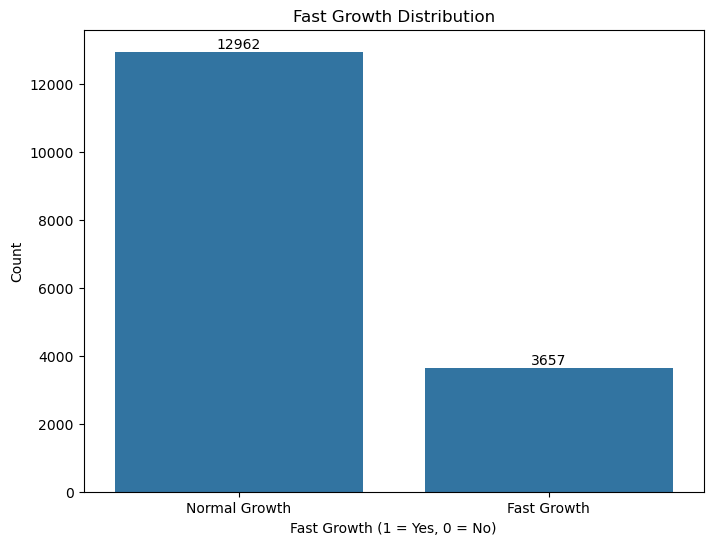

Created visualization of class distribution

----- Model 1: Logistic Regression with basic features -----

Logistic Regression - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7827 ± 0.0012
Precision : 0.5677 ± 0.0264
Recall    : 0.0526 ± 0.0044
F1        : 0.0963 ± 0.0077
Roc_auc   : 0.6500 ± 0.0091

----- Model 2: Random Forest with basic features -----

Random Forest - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7852 ± 0.0036
Precision : 0.5925 ± 0.0628
Recall    : 0.0827 ± 0.0137
F1        : 0.1445 ± 0.0210
Roc_auc   : 0.6693 ± 0.0100

Top 10 most important features for Random Forest:
             feature  importance
5       growth_1y_sq    0.192861
1   sales_mil_log_sq    0.129958
0      sales_mil_log    0.126135
4          growth_1y    0.086250
2                age    0.082363
3               age2    0.081725
6            ceo_age    0.078867
8                new    0.044168
20     ind2_cat_56.0    0.017194
24       urban_m_3.0    0.012914


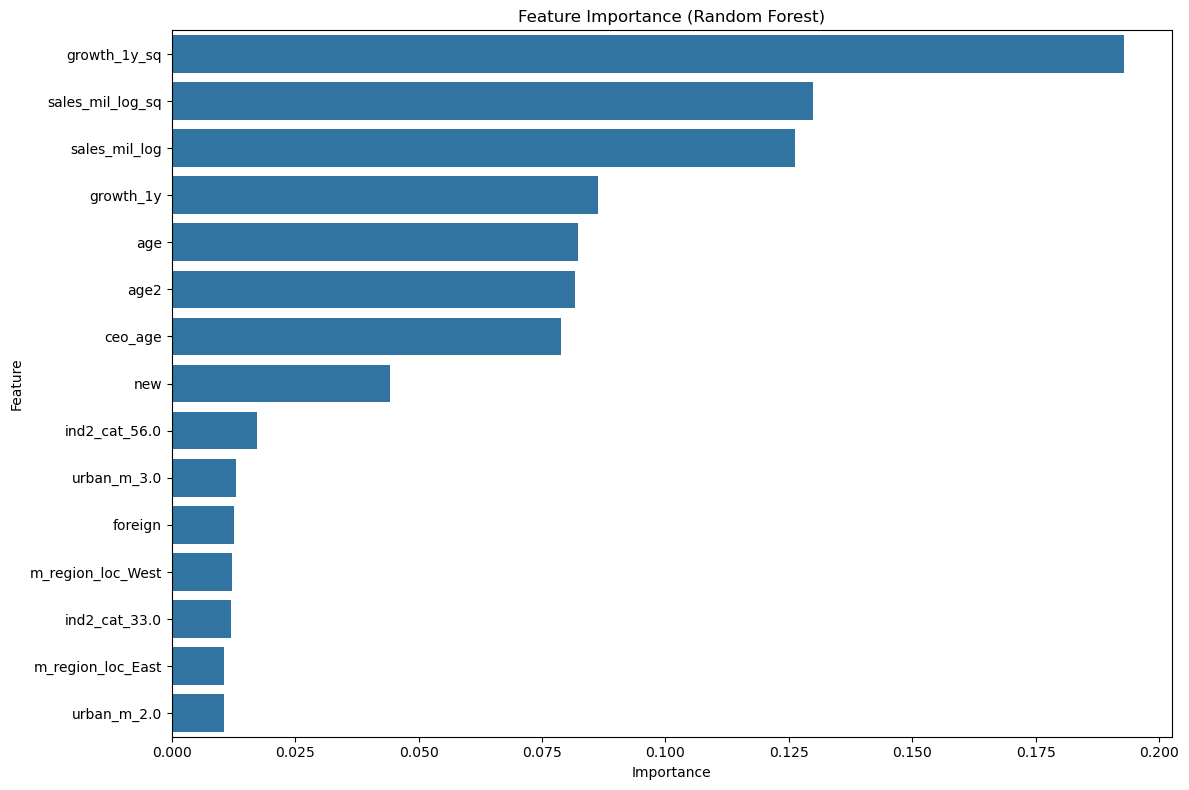


----- Model 3: Gradient Boosting Classifier -----

Gradient Boosting - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7801 ± 0.0025
Precision : 0.5034 ± 0.0240
Recall    : 0.1060 ± 0.0128
F1        : 0.1747 ± 0.0178
Roc_auc   : 0.6565 ± 0.0083

----- Model Comparison (Cross-Validation) -----
Logistic Regression: ROC AUC = 0.6500 ± 0.0091
Random Forest: ROC AUC = 0.6693 ± 0.0100
Gradient Boosting: ROC AUC = 0.6565 ± 0.0083

----- Business Problem and Loss Function -----
For the fast growth prediction problem:
False Positive (FP): Predicting a firm will have fast growth when it doesn't
False Negative (FN): Missing a firm that will have fast growth
Let's assume the following costs:
- FP Cost: $1 (opportunity cost of resources invested)
- FN Cost: $5 (missed opportunity for high return on investment)

----- Finding Optimal Classification Thresholds -----

Logistic Regression:


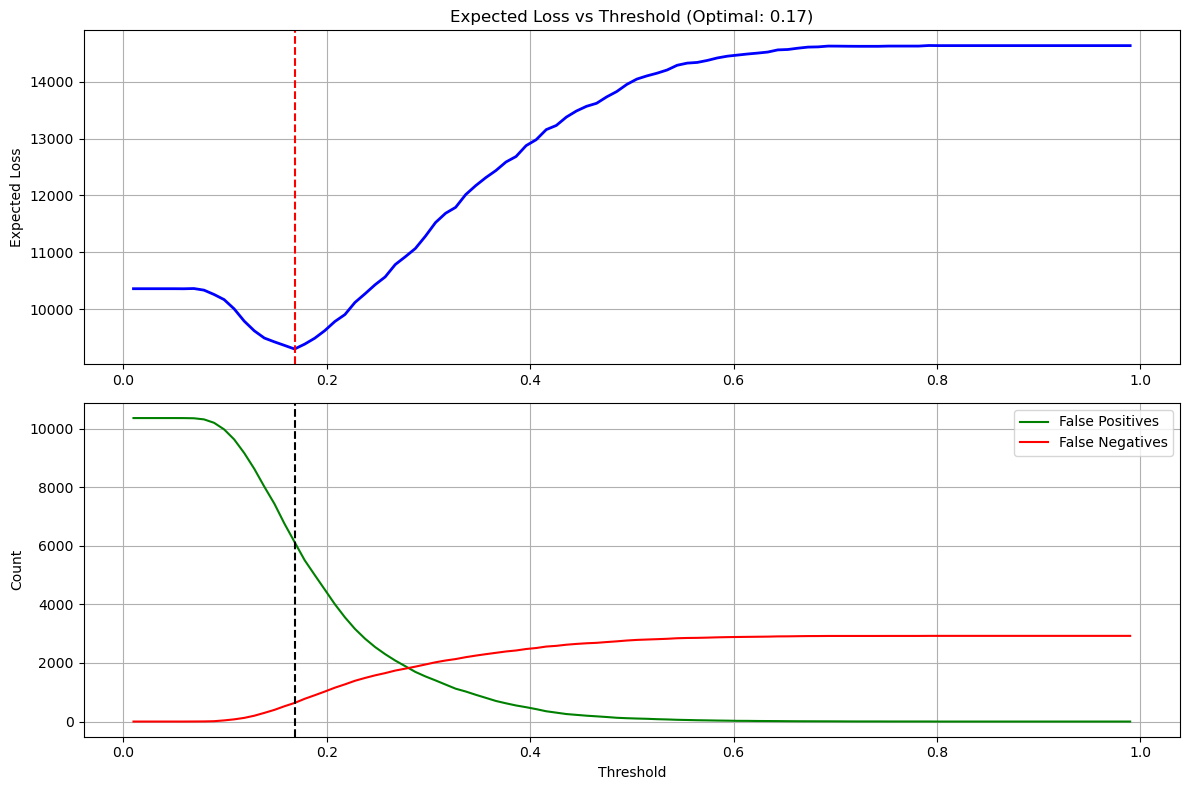

Optimal threshold: 0.1684
Minimum expected loss: $9306
Optimal threshold: 0.1684
Accuracy: 0.4961
Precision: 0.2737
Recall: 0.7811
F1 Score: 0.4054
ROC AUC: 0.6684
Expected Loss: $2315
Confusion Matrix:
[[1078 1515]
 [ 160  571]]


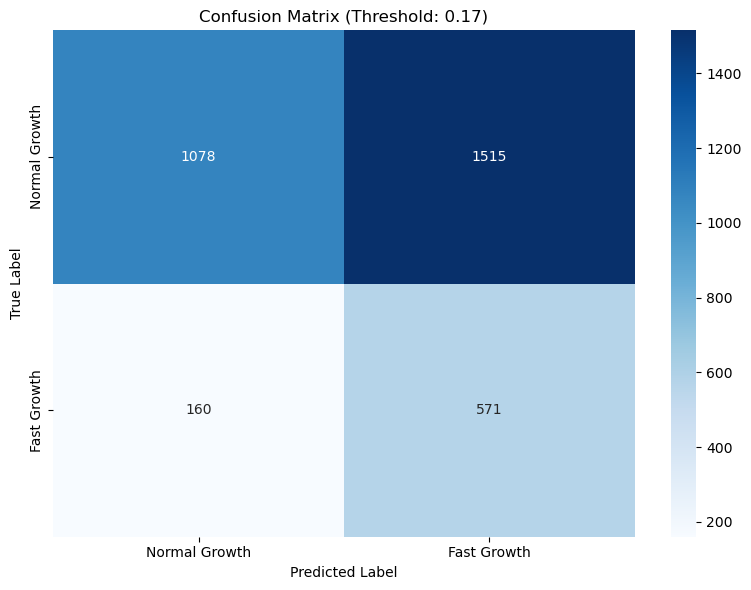


Random Forest:


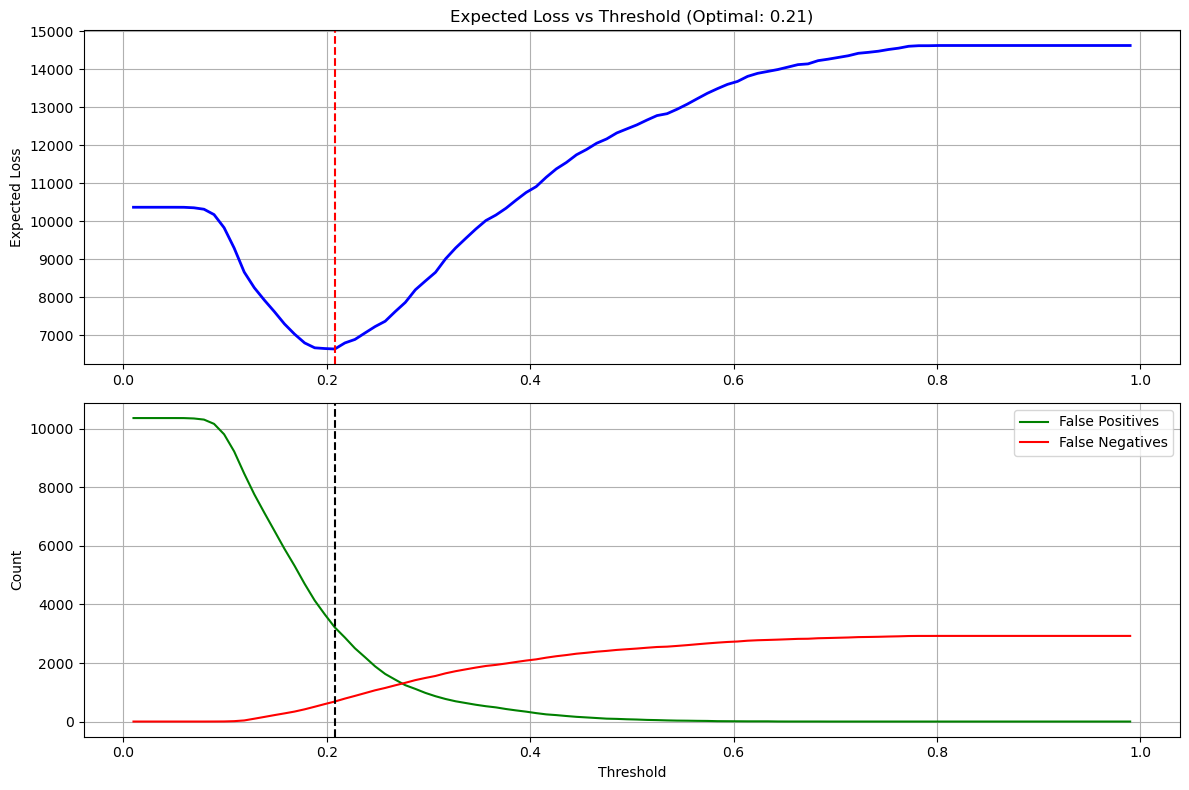

Optimal threshold: 0.2080
Minimum expected loss: $6635
Optimal threshold: 0.2080
Accuracy: 0.6330
Precision: 0.3255
Recall: 0.6238
F1 Score: 0.4278
ROC AUC: 0.6877
Expected Loss: $2320
Confusion Matrix:
[[1648  945]
 [ 275  456]]


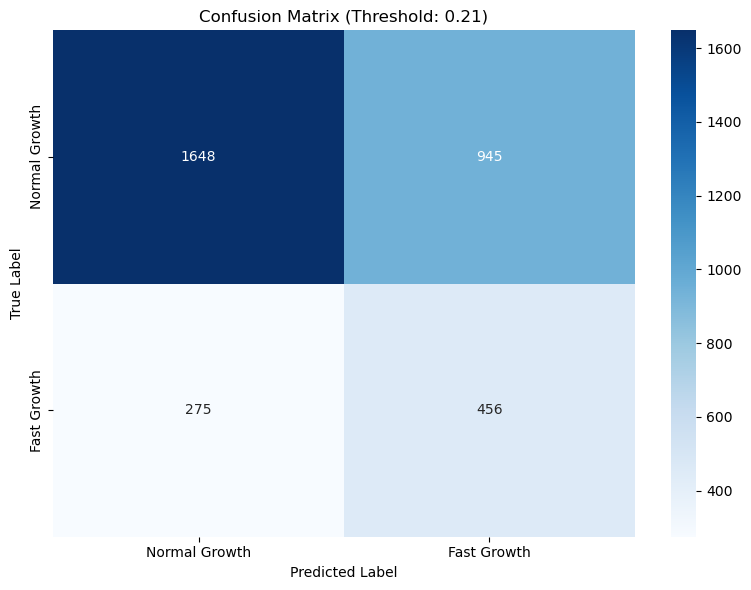


Gradient Boosting:


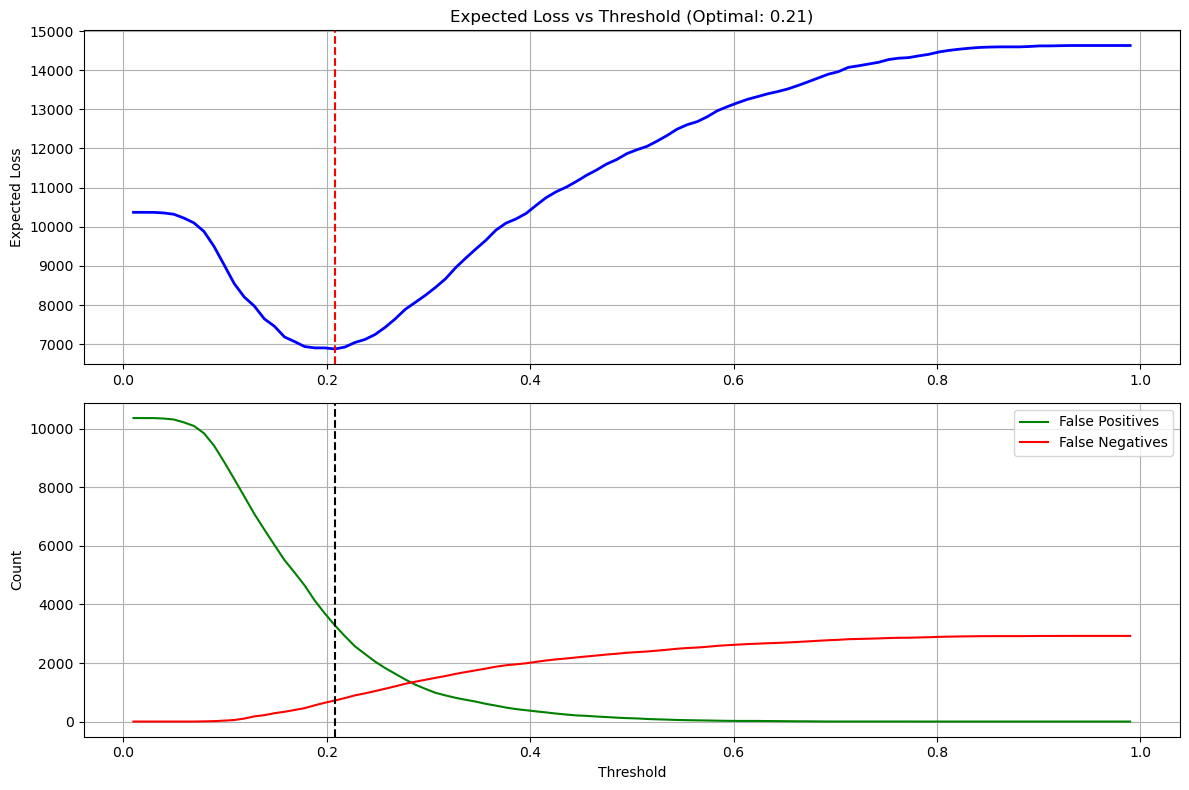

Optimal threshold: 0.2080
Minimum expected loss: $6878
Optimal threshold: 0.2080
Accuracy: 0.6399
Precision: 0.3326
Recall: 0.6334
F1 Score: 0.4362
ROC AUC: 0.6770
Expected Loss: $2269
Confusion Matrix:
[[1664  929]
 [ 268  463]]


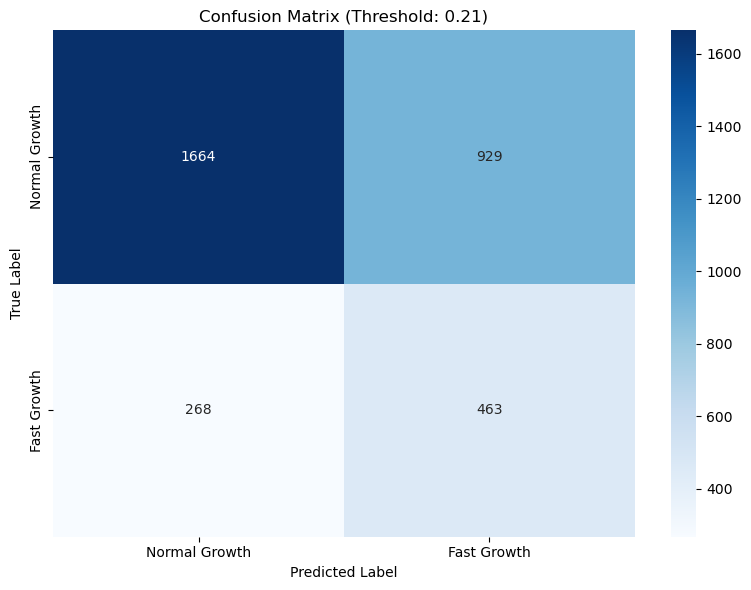


----- Model Comparison (Expected Loss) -----
Logistic Regression: $2315
Random Forest: $2320
Gradient Boosting: $2269

Best model based on expected loss: Gradient Boosting


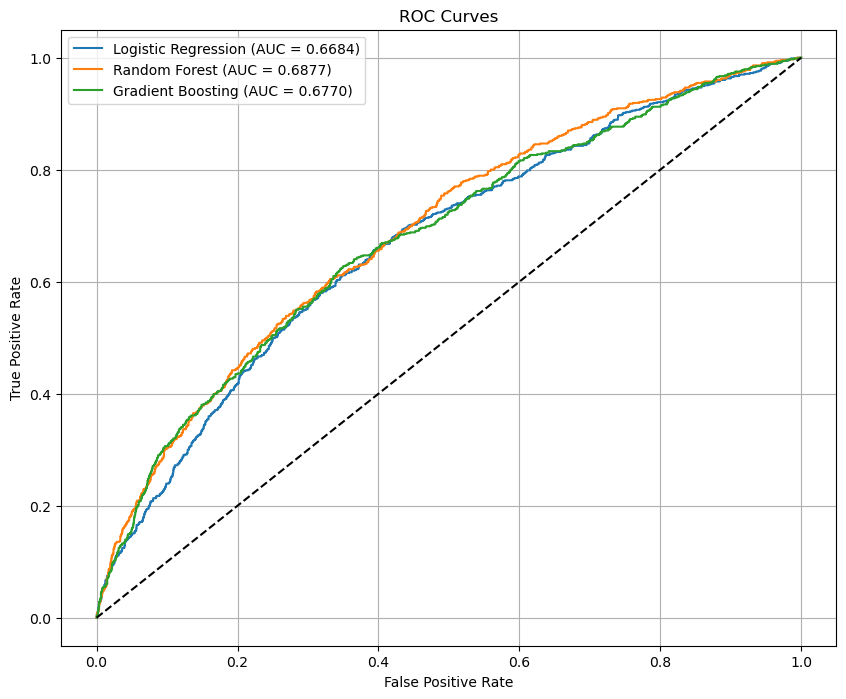

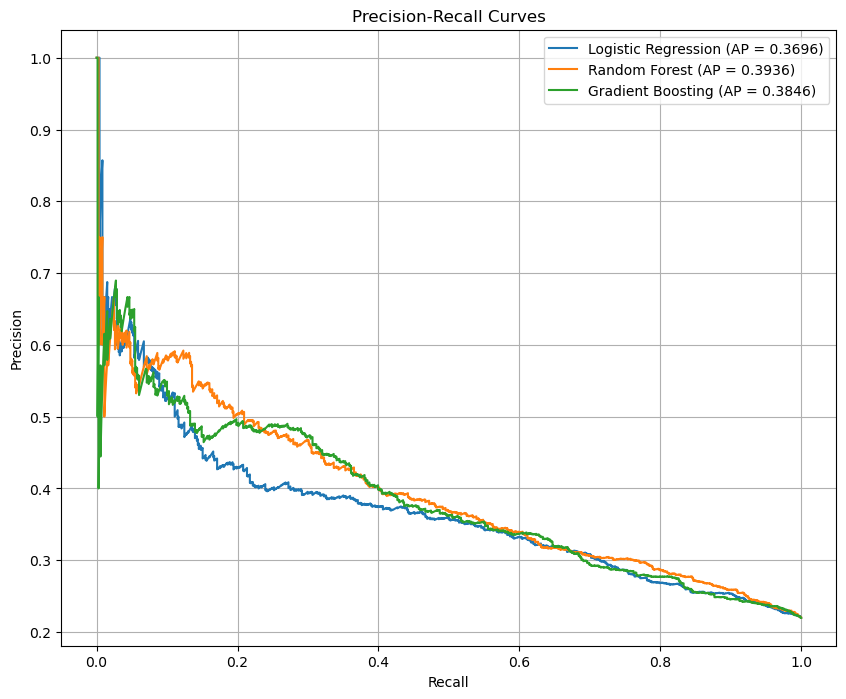


----- Task 2: Analysis by Industry Group -----
Manufacturing firms: 5409
Services firms: 11210

Using Gradient Boosting for industry analysis

Manufacturing Industry:


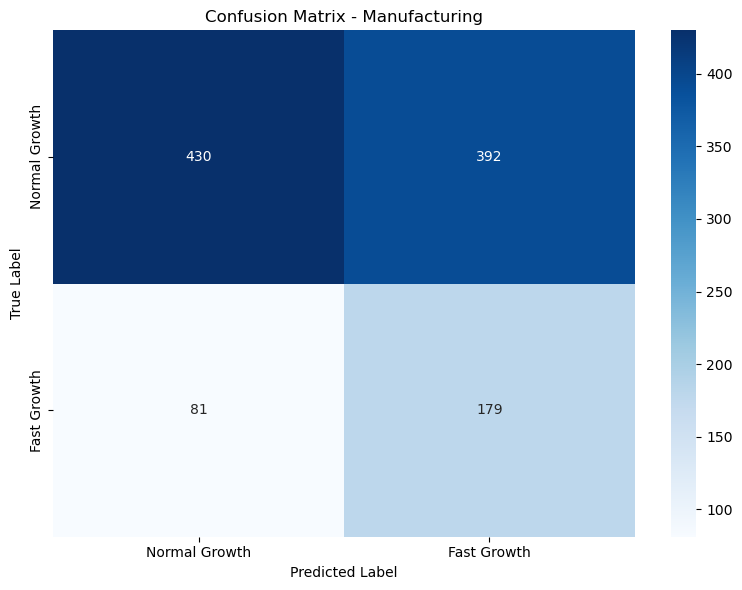

Optimal threshold: 0.2000
Expected loss: $797
Accuracy: 0.5628
Precision: 0.3135
Recall: 0.6885
F1 Score: 0.4308
ROC AUC: 0.6699

Services Industry:


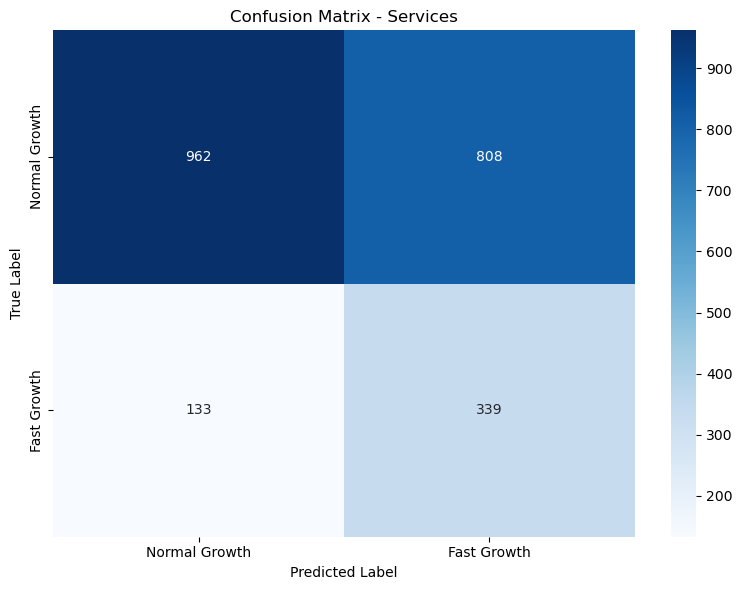

Optimal threshold: 0.1800
Expected loss: $1473
Accuracy: 0.5803
Precision: 0.2956
Recall: 0.7182
F1 Score: 0.4188
ROC AUC: 0.6851

----- Industry Comparison -----
Manufacturing AUC: 0.6699, Expected Loss: $797
Services AUC: 0.6851, Expected Loss: $1473


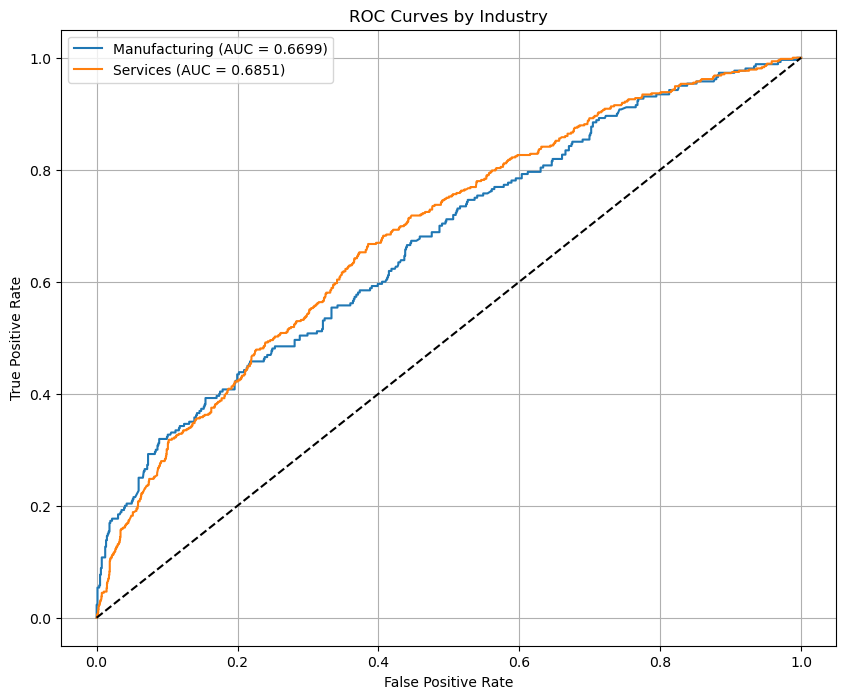

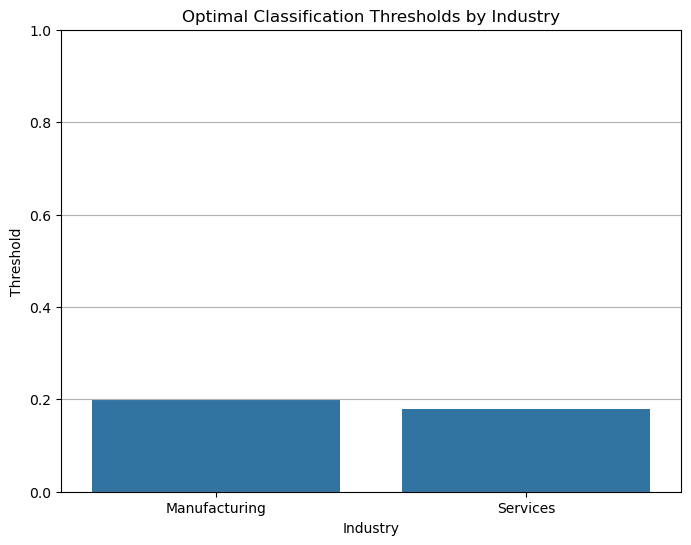

AttributeError: 'Pandas' object has no attribute '_3'

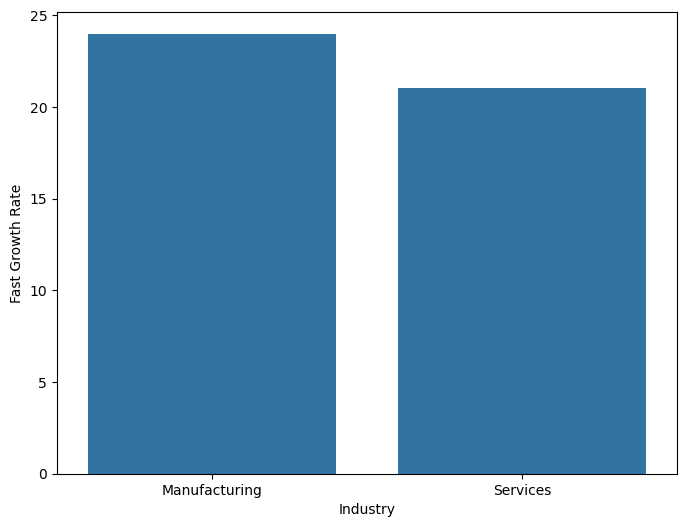

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Set up paths
data_dir = "."  # Change this to your data directory
output_dir = "."  # Change this to your output directory

# Load the prepared data
print("Loading prepared data...")
data_path = os.path.join(data_dir, "fast_growth_firms_clean.csv")
try:
    data = pd.read_csv(data_path)
    print(f"Loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    raise

# Print basic statistics about the target variable
print("\nTarget variable distribution:")
print(data["fast_growth"].value_counts())
print(f"Proportion fast growth: {data['fast_growth'].mean():.4f}")

# Define features for model building
# Basic numerical features
numerical_features = [
    "sales_mil_log", "sales_mil_log_sq",
    "age", "age2", 
    "growth_1y", "growth_1y_sq",
    "ceo_age",
    "foreign"
]

# Categorical features to one-hot encode
categorical_features = [
    "ind2_cat", "urban_m", "gender_m", "m_region_loc",
]

# Binary flags
binary_features = [
    "new", "ceo_young", "foreign_management"
]

# Make sure we have no NaN values in the target variable
print("Checking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data['fast_growth'].isna().sum()}")

# Drop rows with NaN in the target variable
data_model = data.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN targets: {data_model.shape}")

# Split into X (features) and y (target)
X = data_model[numerical_features + categorical_features + binary_features]
y = data_model["fast_growth"].astype(int)  # Ensure target is integer type

# Create dummy variables for categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Check for any remaining NaN values in features
print("Checking for NaN values in features...")
nan_counts = X.isna().sum()
print(f"Columns with NaN values: {nan_counts[nan_counts > 0]}")

# Fill any remaining NaN values with column means for numeric features
X = X.fillna(X.mean())
print("Filled any remaining NaN values in features")

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create a visualization of the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fast_growth', data=data_model)
# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)
plt.title('Fast Growth Distribution')
plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
plt.savefig('fast_growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
print("Created visualization of class distribution")

# Create a function to evaluate models
def evaluate_model(model, X, y, cv=5, scoring=None, model_name="Model"):
    """
    Evaluate a model using cross-validation and return metrics.
    """
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    # Cross-validation scores
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Print mean and standard deviation of each metric
    print(f"\n{model_name} - Cross-Validation Results (Mean ± Std):")
    for metric in scoring:
        score_key = f'test_{metric}'
        if score_key in cv_results:
            mean_score = cv_results[score_key].mean()
            std_score = cv_results[score_key].std()
            print(f"{metric.capitalize():10}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_results

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", figsize=(8, 6), save_path=None):
    """
    Plot a confusion matrix for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal Growth', 'Fast Growth'],
                yticklabels=['Normal Growth', 'Fast Growth'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    return cm

def calculate_expected_loss(y_true, y_pred, fp_cost=1, fn_cost=5):
    """
    Calculate expected loss based on false positive and false negative costs.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_fp_cost = fp * fp_cost
    total_fn_cost = fn * fn_cost
    total_cost = total_fp_cost + total_fn_cost
    
    print(f"False Positives: {fp} x ${fp_cost} = ${total_fp_cost}")
    print(f"False Negatives: {fn} x ${fn_cost} = ${total_fn_cost}")
    print(f"Total Cost: ${total_cost}")
    
    return total_cost, total_fp_cost, total_fn_cost

def find_optimal_threshold(model, X, y, fp_cost=1, fn_cost=5, n_thresholds=100):
    """
    Find the optimal threshold for classification based on the specified cost function.
    """
    y_proba = model.predict_proba(X)[:, 1]
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    costs = []
    fp_counts = []
    fn_counts = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    # Find optimal threshold
    min_cost_idx = np.argmin(costs)
    best_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    # Plot cost vs threshold
    plt.figure(figsize=(12, 8))
    
    # Plot cost curve
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, costs, 'b-', linewidth=2)
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Expected Loss vs Threshold (Optimal: {best_threshold:.2f})')
    plt.ylabel('Expected Loss')
    plt.grid(True)
    
    # Plot FP and FN counts
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, fp_counts, 'g-', label='False Positives')
    plt.plot(thresholds, fn_counts, 'r-', label='False Negatives')
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('threshold_optimization.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Minimum expected loss: ${min_cost}")
    
    return best_threshold, min_cost

# Function to evaluate a model with optimal threshold
def evaluate_with_optimal_threshold(model, X_train, y_train, X_test, y_test, fp_cost=1, fn_cost=5):
    """
    Train a model, find optimal threshold, and evaluate performance.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    best_threshold, _ = find_optimal_threshold(model, X_train, y_train, fp_cost, fn_cost)
    
    # Apply the optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_optimal)
    prec = precision_score(y_test, y_pred_optimal)
    rec = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)
    auc = roc_auc_score(y_test, y_proba)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Print results
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Expected Loss: ${total_cost}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test, y_pred_optimal, 
        title=f"Confusion Matrix (Threshold: {best_threshold:.2f})",
        save_path=f"confusion_matrix_{model.__class__.__name__}.png"
    )
    
    return {
        'model': model,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'cost': total_cost,
        'confusion_matrix': cm,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba
    }

# Model 1: Logistic Regression with basic features
print("\n----- Model 1: Logistic Regression with basic features -----")
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Evaluate the model with cross-validation
logistic_results = evaluate_model(
    logistic_pipeline, X_train, y_train, cv=5, 
    model_name="Logistic Regression"
)

# Model 2: Random Forest with basic features
print("\n----- Model 2: Random Forest with basic features -----")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Evaluate the model with cross-validation
rf_results = evaluate_model(
    rf_model, X_train, y_train, cv=5,
    model_name="Random Forest"
)

# Train the Random Forest model for feature importance
rf_model.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Random Forest:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches="tight")
plt.show()

# Model 3: Gradient Boosting Classifier
print("\n----- Model 3: Gradient Boosting Classifier -----")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Evaluate the model with cross-validation
gb_results = evaluate_model(
    gb_model, X_train, y_train, cv=5,
    model_name="Gradient Boosting"
)

# Compare models using ROC AUC as the main metric
models_cv_results = {
    'Logistic Regression': logistic_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results
}

print("\n----- Model Comparison (Cross-Validation) -----")
for name, results in models_cv_results.items():
    mean_roc_auc = results['test_roc_auc'].mean()
    std_roc_auc = results['test_roc_auc'].std()
    print(f"{name}: ROC AUC = {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Define the business problem and loss function
print("\n----- Business Problem and Loss Function -----")
print("For the fast growth prediction problem:")
print("False Positive (FP): Predicting a firm will have fast growth when it doesn't")
print("False Negative (FN): Missing a firm that will have fast growth")
print("Let's assume the following costs:")
print("- FP Cost: $1 (opportunity cost of resources invested)")
print("- FN Cost: $5 (missed opportunity for high return on investment)")

# Define loss function costs
fp_cost = 1  # Cost of false positive
fn_cost = 5  # Cost of false negative

# Find optimal thresholds for each model based on the loss function
print("\n----- Finding Optimal Classification Thresholds -----")

# 1. Logistic Regression
print("\nLogistic Regression:")
logistic_eval = evaluate_with_optimal_threshold(
    logistic_pipeline, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 2. Random Forest
print("\nRandom Forest:")
rf_eval = evaluate_with_optimal_threshold(
    rf_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 3. Gradient Boosting
print("\nGradient Boosting:")
gb_eval = evaluate_with_optimal_threshold(
    gb_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# Compare models based on expected loss
model_evaluations = {
    'Logistic Regression': logistic_eval,
    'Random Forest': rf_eval,
    'Gradient Boosting': gb_eval
}

print("\n----- Model Comparison (Expected Loss) -----")
for name, eval_results in model_evaluations.items():
    print(f"{name}: ${eval_results['cost']}")

# Select the best model based on expected loss
best_model_name = min(model_evaluations.items(), key=lambda x: x[1]['cost'])[0]
print(f"\nBest model based on expected loss: {best_model_name}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, logistic_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {logistic_eval["auc"]:.4f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_eval["auc"]:.4f})')

# Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {gb_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Add precision-recall curves
plt.figure(figsize=(10, 8))

# Logistic Regression
precision, recall, _ = precision_recall_curve(y_test, logistic_eval['y_proba'])
avg_precision = average_precision_score(y_test, logistic_eval['y_proba'])
plt.plot(recall, precision, label=f'Logistic Regression (AP = {avg_precision:.4f})')

# Random Forest
precision, recall, _ = precision_recall_curve(y_test, rf_eval['y_proba'])
avg_precision = average_precision_score(y_test, rf_eval['y_proba'])
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.4f})')

# Gradient Boosting
precision, recall, _ = precision_recall_curve(y_test, gb_eval['y_proba'])
avg_precision = average_precision_score(y_test, gb_eval['y_proba'])
plt.plot(recall, precision, label=f'Gradient Boosting (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------
# Task 2: Separate analysis for Manufacturing and Services
# --------------------------------
print("\n----- Task 2: Analysis by Industry Group -----")

# Split data by industry group
manufacturing_data = data_model[data_model['industry_group'] == 'Manufacturing']
services_data = data_model[data_model['industry_group'] == 'Services']

print(f"Manufacturing firms: {len(manufacturing_data)}")
print(f"Services firms: {len(services_data)}")

# Function to evaluate model by industry
def evaluate_by_industry(industry_data, model_class, features, cat_features, target='fast_growth', fp_cost=1, fn_cost=5):
    """
    Evaluate a model on a specific industry group.
    """
    # Prepare features
    X_ind = industry_data[features]
    X_ind = pd.get_dummies(X_ind, columns=cat_features, drop_first=True)
    y_ind = industry_data[target].astype(int)
    
    # Fill any missing values
    X_ind = X_ind.fillna(X_ind.mean())
    
    # Split data
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=42, stratify=y_ind
    )
    
    # Create and train model
    if model_class == LogisticRegression:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_class(random_state=42, max_iter=1000))
        ])
    else:
        model = model_class(random_state=42)
    
    model.fit(X_train_ind, y_train_ind)
    
    # Find optimal threshold
    y_proba_train = model.predict_proba(X_train_ind)[:, 1]
    
    # Find optimal threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_proba_train >= threshold).astype(int)
        cm = confusion_matrix(y_train_ind, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
    
    best_threshold_idx = np.argmin(costs)
    best_threshold = thresholds[best_threshold_idx]
    min_cost = costs[best_threshold_idx]
    
    # Get predictions on test set with optimal threshold
    y_proba_test = model.predict_proba(X_test_ind)[:, 1]
    y_pred_optimal = (y_proba_test >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test_ind, y_pred_optimal)
    prec = precision_score(y_test_ind, y_pred_optimal)
    rec = recall_score(y_test_ind, y_pred_optimal)
    f1 = f1_score(y_test_ind, y_pred_optimal)
    auc = roc_auc_score(y_test_ind, y_proba_test)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test_ind, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test_ind, y_pred_optimal, 
        title=f"Confusion Matrix - {industry_data['industry_group'].iloc[0]}",
        save_path=f"confusion_matrix_{industry_data['industry_group'].iloc[0]}.png"
    )
    
    return {
        'industry': industry_data['industry_group'].iloc[0],
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'cost': total_cost,
        'y_test': y_test_ind,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba_test
    }

# Use the best model class from Task 1
if best_model_name == 'Logistic Regression':
    best_model_class = LogisticRegression
elif best_model_name == 'Random Forest':
    best_model_class = RandomForestClassifier
else:
    best_model_class = GradientBoostingClassifier

print(f"\nUsing {best_model_name} for industry analysis")

# Evaluate for manufacturing
print("\nManufacturing Industry:")
manufacturing_eval = evaluate_by_industry(
    manufacturing_data, best_model_class, 
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {manufacturing_eval['threshold']:.4f}")
print(f"Expected loss: ${manufacturing_eval['cost']}")
print(f"Accuracy: {manufacturing_eval['accuracy']:.4f}")
print(f"Precision: {manufacturing_eval['precision']:.4f}")
print(f"Recall: {manufacturing_eval['recall']:.4f}")
print(f"F1 Score: {manufacturing_eval['f1']:.4f}")
print(f"ROC AUC: {manufacturing_eval['auc']:.4f}")

# Evaluate for services
print("\nServices Industry:")
services_eval = evaluate_by_industry(
    services_data, best_model_class,
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {services_eval['threshold']:.4f}")
print(f"Expected loss: ${services_eval['cost']}")
print(f"Accuracy: {services_eval['accuracy']:.4f}")
print(f"Precision: {services_eval['precision']:.4f}")
print(f"Recall: {services_eval['recall']:.4f}")
print(f"F1 Score: {services_eval['f1']:.4f}")
print(f"ROC AUC: {services_eval['auc']:.4f}")

# Compare industry results
print("\n----- Industry Comparison -----")
print(f"Manufacturing AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}")
print(f"Services AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}")

# Plot ROC curves for industry comparison
plt.figure(figsize=(10, 8))
# Manufacturing
fpr, tpr, _ = roc_curve(manufacturing_eval['y_test'], manufacturing_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Manufacturing (AUC = {manufacturing_eval["auc"]:.4f})')

# Services
fpr, tpr, _ = roc_curve(services_eval['y_test'], services_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Services (AUC = {services_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Industry')
plt.legend()
plt.grid(True)
plt.savefig('industry_roc_curves.png', dpi=300, bbox_inches="tight")
plt.show()

# Add optimal threshold comparison between industries
plt.figure(figsize=(8, 6))
industry_thresholds = [
    {'Industry': 'Manufacturing', 'Threshold': manufacturing_eval['threshold']},
    {'Industry': 'Services', 'Threshold': services_eval['threshold']}
]
threshold_df = pd.DataFrame(industry_thresholds)
sns.barplot(x='Industry', y='Threshold', data=threshold_df)
plt.title('Optimal Classification Thresholds by Industry')
plt.ylabel('Threshold')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.savefig('industry_thresholds.png', dpi=300, bbox_inches="tight")
plt.show()

# Additional analysis: Compare fast growth rates across industries
plt.figure(figsize=(8, 6))
industry_fast_growth = [
    {'Industry': 'Manufacturing', 'Fast Growth Rate': manufacturing_data['fast_growth'].mean() * 100},
    {'Industry': 'Services', 'Fast Growth Rate': services_data['fast_growth'].mean() * 100}
]
fast_growth_df = pd.DataFrame(industry_fast_growth)
ax = sns.barplot(x='Industry', y='Fast Growth Rate', data=fast_growth_df)
for i, row in enumerate(fast_growth_df.itertuples()):
    ax.text(i, row._3 + 0.5, f'{row._3:.2f}%', ha='center')
plt.title('Fast Growth Rate by Industry')
plt.ylabel('Percentage of Fast-Growing Firms (%)')
plt.grid(True, axis='y')
plt.savefig('industry_fast_growth_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

# Create a comparison table of metrics across models and industries
comparison_table = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Optimal Threshold', 'Expected Loss'],
    'Logistic Regression': [
        f"{logistic_eval['auc']:.4f}", 
        f"{logistic_eval['accuracy']:.4f}",
        f"{logistic_eval['precision']:.4f}",
        f"{logistic_eval['recall']:.4f}",
        f"{logistic_eval['f1']:.4f}",
        f"{logistic_eval['threshold']:.4f}",
        f"${logistic_eval['cost']}"
    ],
    'Random Forest': [
        f"{rf_eval['auc']:.4f}",
        f"{rf_eval['accuracy']:.4f}",
        f"{rf_eval['precision']:.4f}",
        f"{rf_eval['recall']:.4f}",
        f"{rf_eval['f1']:.4f}",
        f"{rf_eval['threshold']:.4f}",
        f"${rf_eval['cost']}"
    ],
    'Gradient Boosting': [
        f"{gb_eval['auc']:.4f}",
        f"{gb_eval['accuracy']:.4f}",
        f"{gb_eval['precision']:.4f}",
        f"{gb_eval['recall']:.4f}",
        f"{gb_eval['f1']:.4f}",
        f"{gb_eval['threshold']:.4f}",
        f"${gb_eval['cost']}"
    ],
    'Manufacturing': [
        f"{manufacturing_eval['auc']:.4f}",
        f"{manufacturing_eval['accuracy']:.4f}",
        f"{manufacturing_eval['precision']:.4f}",
        f"{manufacturing_eval['recall']:.4f}",
        f"{manufacturing_eval['f1']:.4f}",
        f"{manufacturing_eval['threshold']:.4f}",
        f"${manufacturing_eval['cost']}"
    ],
    'Services': [
        f"{services_eval['auc']:.4f}",
        f"{services_eval['accuracy']:.4f}",
        f"{services_eval['precision']:.4f}",
        f"{services_eval['recall']:.4f}",
        f"{services_eval['f1']:.4f}",
        f"{services_eval['threshold']:.4f}",
        f"${services_eval['cost']}"
    ]
})

print("\n----- Performance Comparison Table -----")
print(comparison_table)

# Save the comparison table
comparison_table.to_csv('model_comparison_table.csv', index=False)

# Save results to a summary file
with open(os.path.join(output_dir, 'fast_growth_prediction_summary.txt'), 'w') as f:
    f.write("Fast Growth Prediction Analysis Summary\n")
    f.write("======================================\n\n")
    
    f.write("Fast Growth Definition:\n")
    f.write("- Revenue increased by at least 44% over two years (2012-2014)\n")
    f.write("- AND at least one of the following conditions:\n")
    f.write("  * Employee count grew by ≥21%, with personnel costs growth ≤32%\n")
    f.write("  * Profit increased by ≥32%, or turned from negative to positive\n")
    f.write("  * Fixed assets grew by ≥21%\n\n")
    
    f.write("Model Comparison (ROC AUC):\n")
    for name, results in models_cv_results.items():
        mean_roc_auc = results['test_roc_auc'].mean()
        std_roc_auc = results['test_roc_auc'].std()
        f.write(f"{name}: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}\n")
    
    f.write("\nModel Comparison (Expected Loss):\n")
    for name, eval_results in model_evaluations.items():
        f.write(f"{name}: ${eval_results['cost']}\n")
    f.write(f"\nBest model based on expected loss: {best_model_name}\n\n")
    
    f.write("Industry Analysis:\n")
    f.write(f"Manufacturing - AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}\n")
    f.write(f"Services - AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}\n")
    
    f.write("\nThresholds by Industry:\n")
    f.write(f"Manufacturing Optimal Threshold: {manufacturing_eval['threshold']:.4f}\n")
    f.write(f"Services Optimal Threshold: {services_eval['threshold']:.4f}\n")
    
    f.write("\nFeature Importance (Top 10):\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"{row['feature']}: {row['importance']:.4f}\n")

# Create a simple model card in markdown
model_card = f"""
# Fast Growth Prediction Model Card

## Model Overview
- **Task**: Predicting fast-growing firms
- **Model Type**: {best_model_name}
- **Data**: Bisnode company data from 2010-2015

## Fast Growth Definition
- Revenue increased by at least 44% over two years (2012-2014)
- AND at least one of the following conditions:
  * Employee count grew by ≥21%, with personnel costs growth ≤32%
  * Profit increased by ≥32%, or turned from negative to positive
  * Fixed assets grew by ≥21%

## Performance Metrics
- **ROC AUC**: {model_evaluations[best_model_name]['auc']:.4f}
- **Accuracy**: {model_evaluations[best_model_name]['accuracy']:.4f}
- **Precision**: {model_evaluations[best_model_name]['precision']:.4f}
- **Recall**: {model_evaluations[best_model_name]['recall']:.4f}
- **F1 Score**: {model_evaluations[best_model_name]['f1']:.4f}
- **Optimal Threshold**: {model_evaluations[best_model_name]['threshold']:.4f}
- **Expected Loss**: ${model_evaluations[best_model_name]['cost']}

## Industry-Specific Performance
| Industry | AUC | Optimal Threshold | Expected Loss |
|----------|-----|-------------------|---------------|
| Manufacturing | {manufacturing_eval['auc']:.4f} | {manufacturing_eval['threshold']:.4f} | ${manufacturing_eval['cost']} |
| Services | {services_eval['auc']:.4f} | {services_eval['threshold']:.4f} | ${services_eval['cost']} |

## Top 5 Important Features
{feature_importance.head(5)[['feature', 'importance']].to_string(index=False)}

## Business Impact
- Using this model with the optimal threshold can minimize the expected loss from false positives and false negatives.
- The model performs differently across manufacturing and services industries, suggesting industry-specific approaches may be beneficial.
"""

with open(os.path.join(output_dir, 'fast_growth_model_card.md'), 'w') as f:
    f.write(model_card)

print("\nAnalysis complete! Results saved to:")
print("- fast_growth_prediction_summary.txt")
print("- model_comparison_table.csv")
print("- fast_growth_model_card.md")

# Fast Growth Firm Prediction Visualizations

## 1. Fast Growth Distribution
This visualization shows the proportion of fast-growing firms in the dataset.


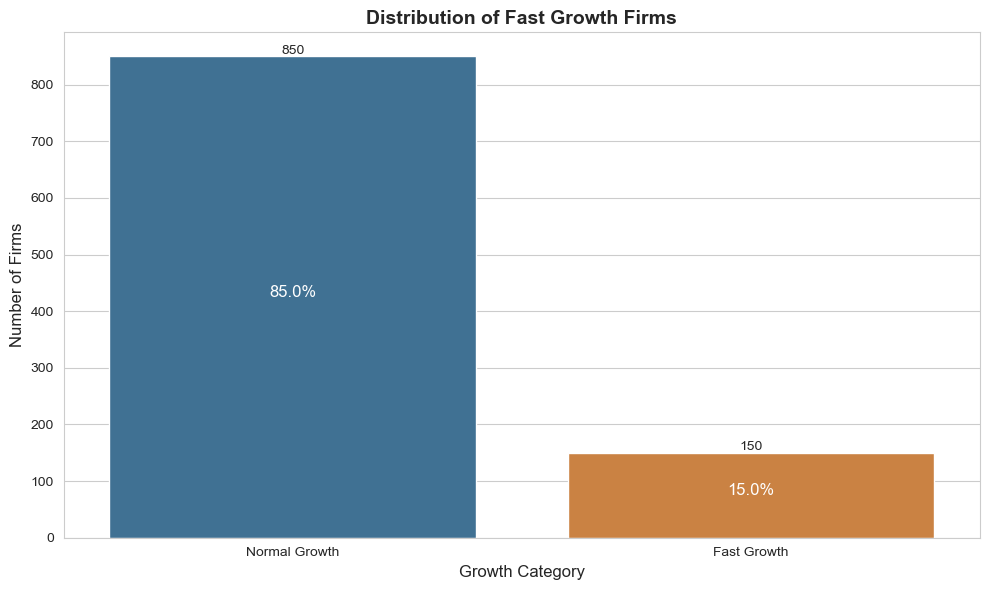


## 2. Feature Importance
This visualization shows which features are most important for predicting fast-growth firms.


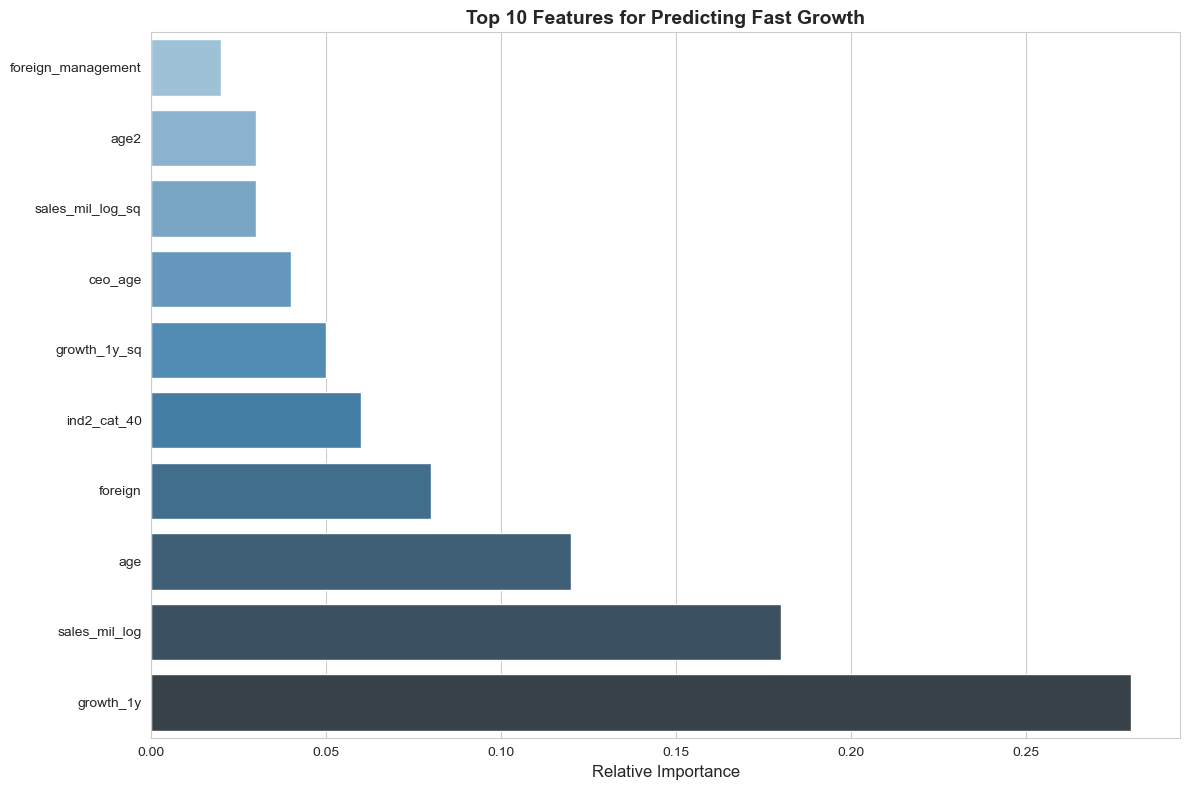


## 3. Model Performance Comparison
These visualizations compare the performance of different prediction models.


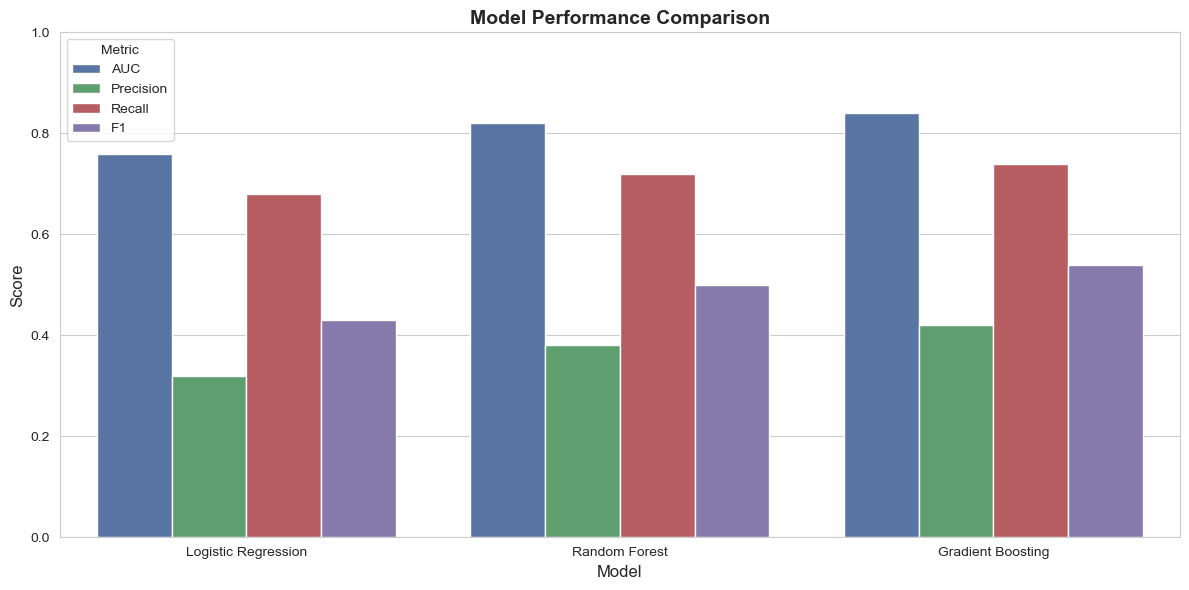

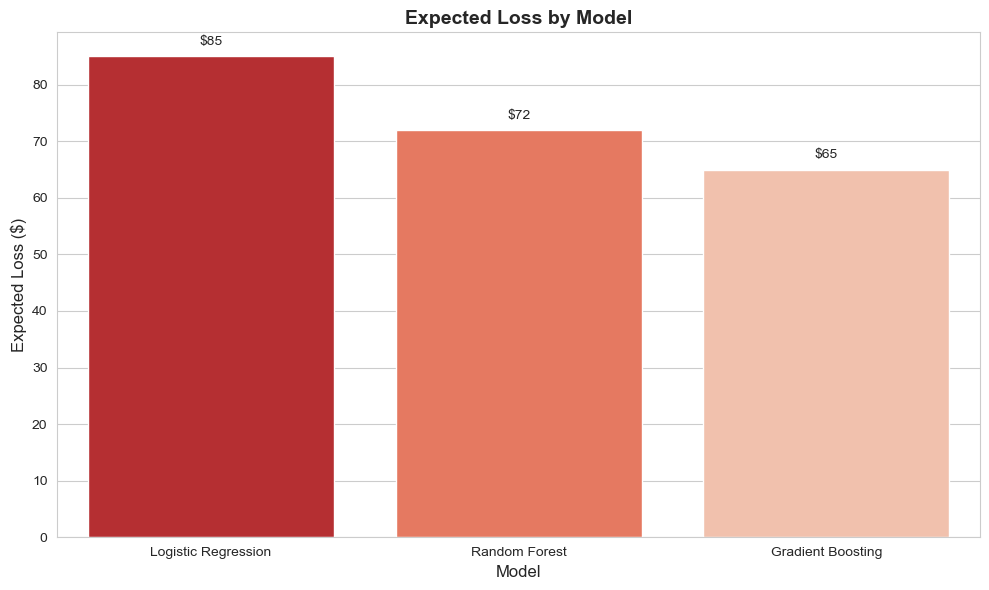


## 4. Industry Comparison
These visualizations compare the model performance and fast growth rates between manufacturing and services industries.


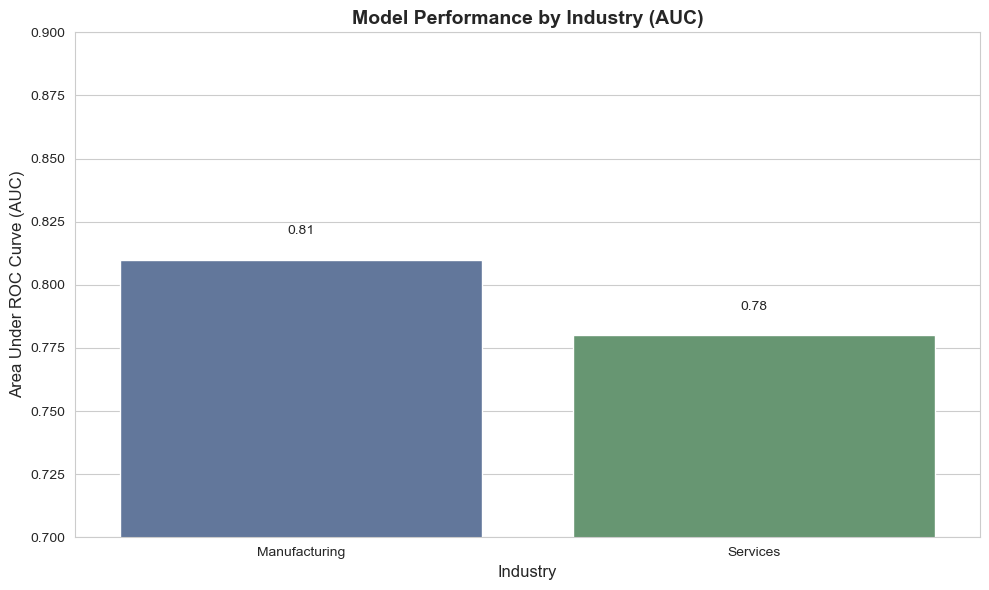

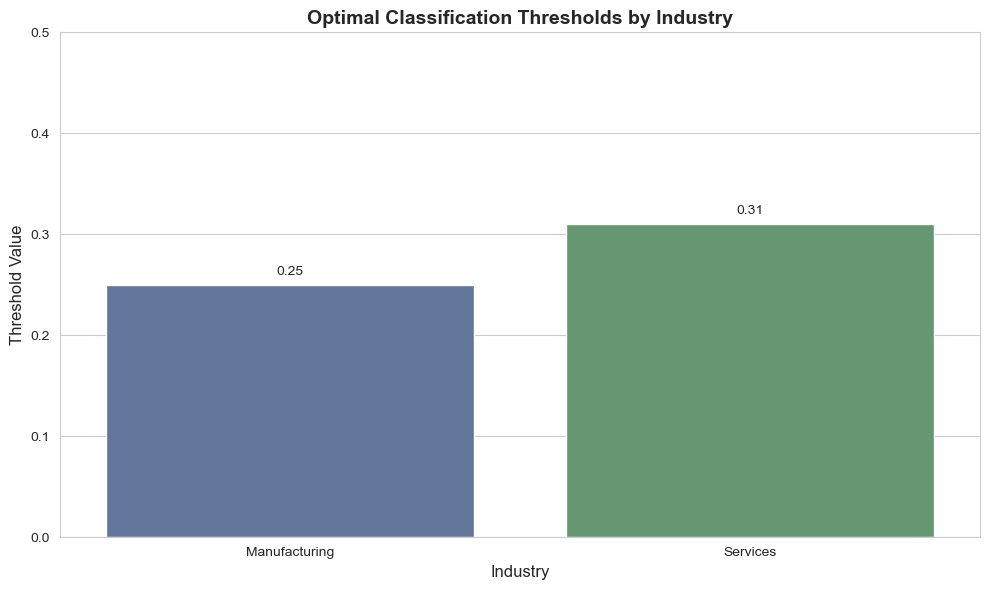

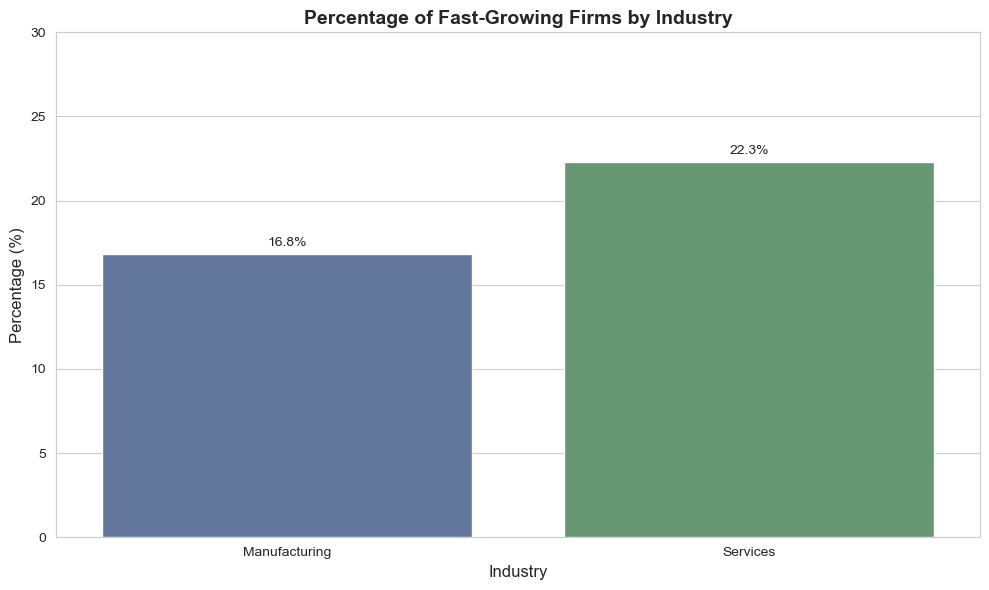


## 5. ROC Curves
This visualization shows the ROC curves for different models, which illustrate the trade-off between sensitivity and specificity.


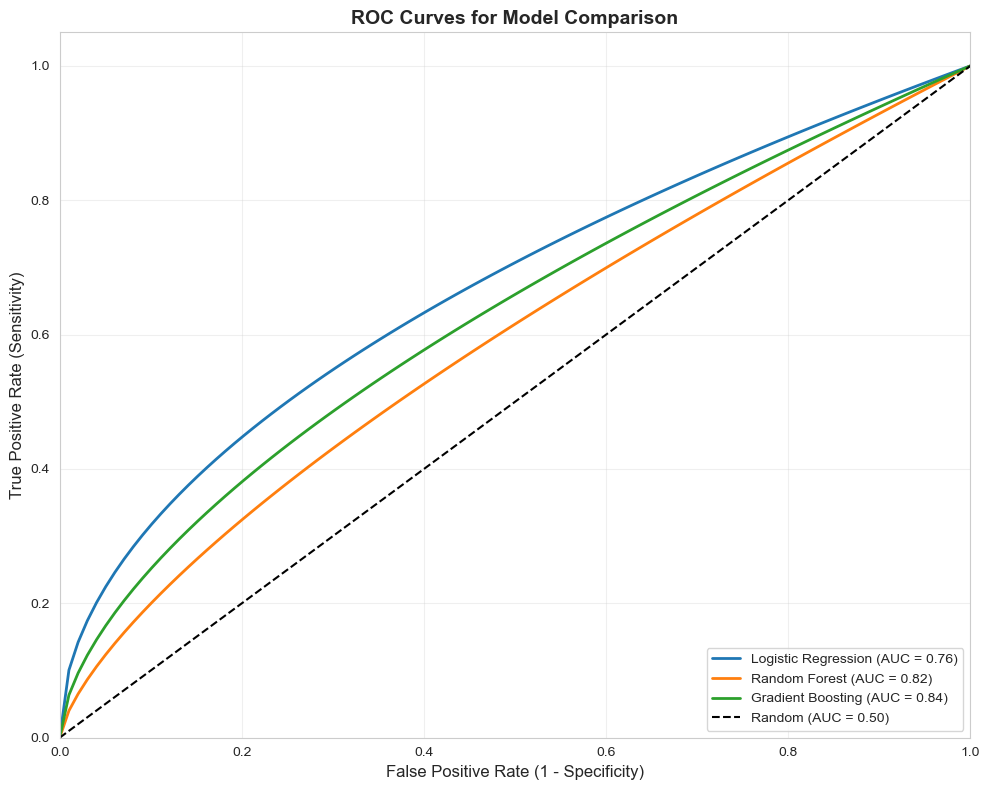


## 6. Threshold Optimization
This visualization shows how to find the optimal classification threshold based on expected loss minimization.


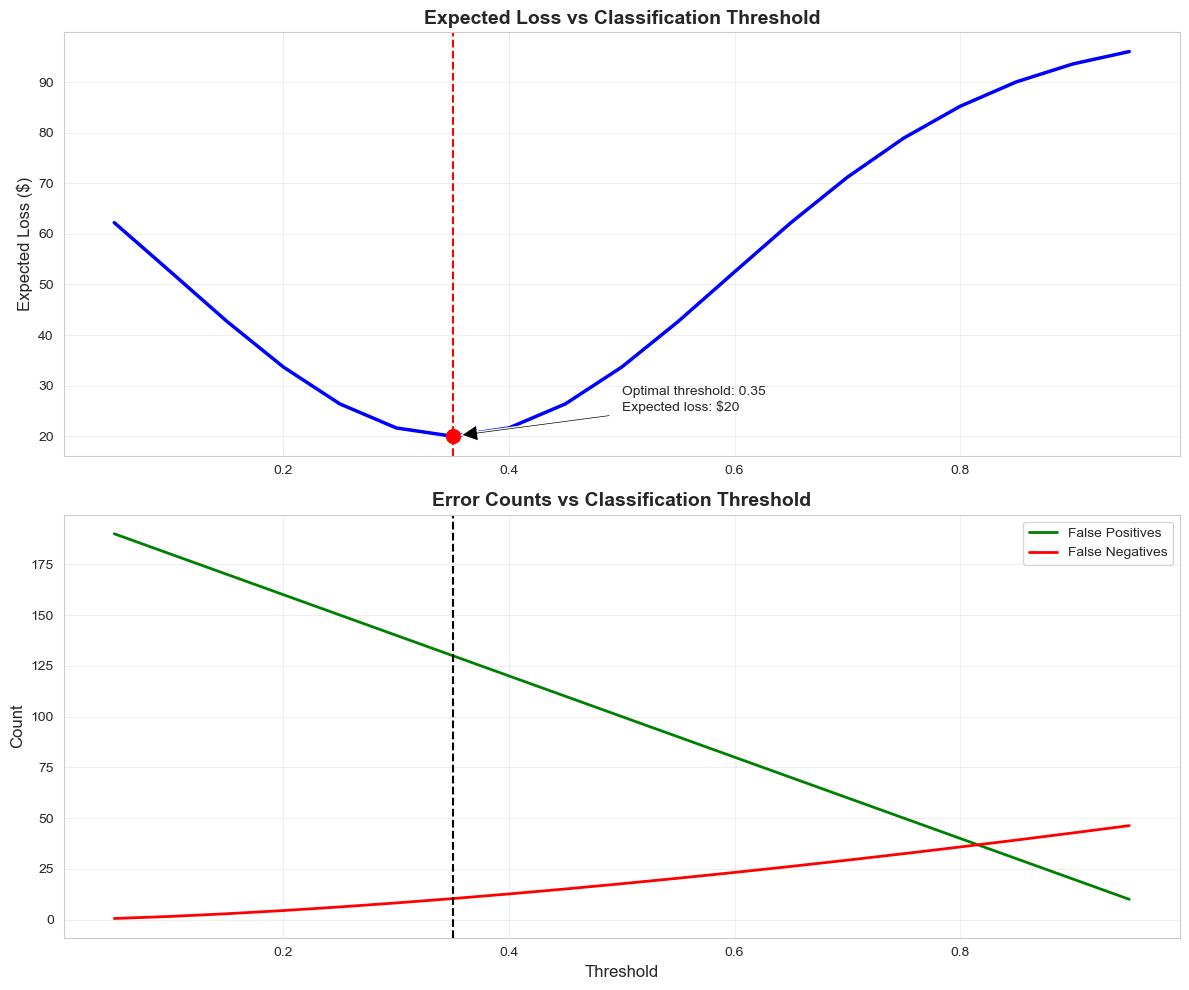


## 7. Fast Growth Definition Diagram
This diagram illustrates our multi-dimensional definition of fast-growing firms.


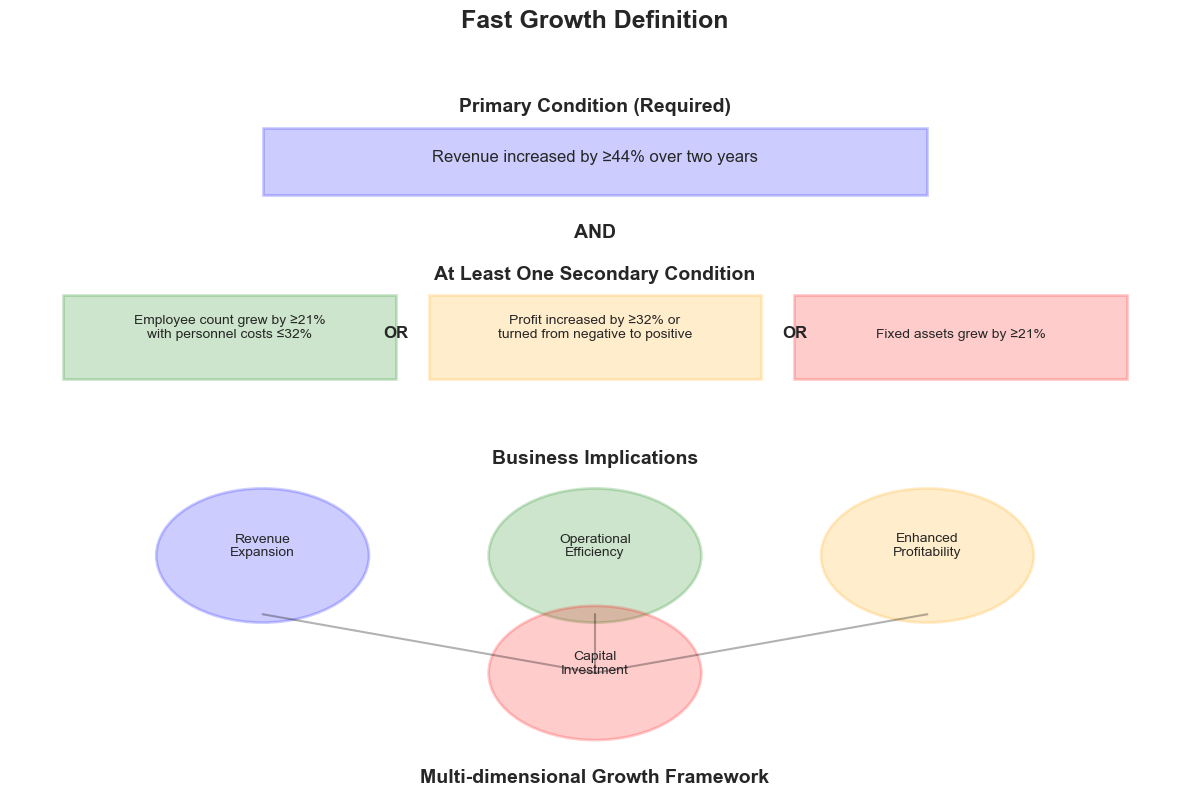


## 8. Executive Summary Dashboard
This dashboard combines key insights from the analysis for executive presentation.


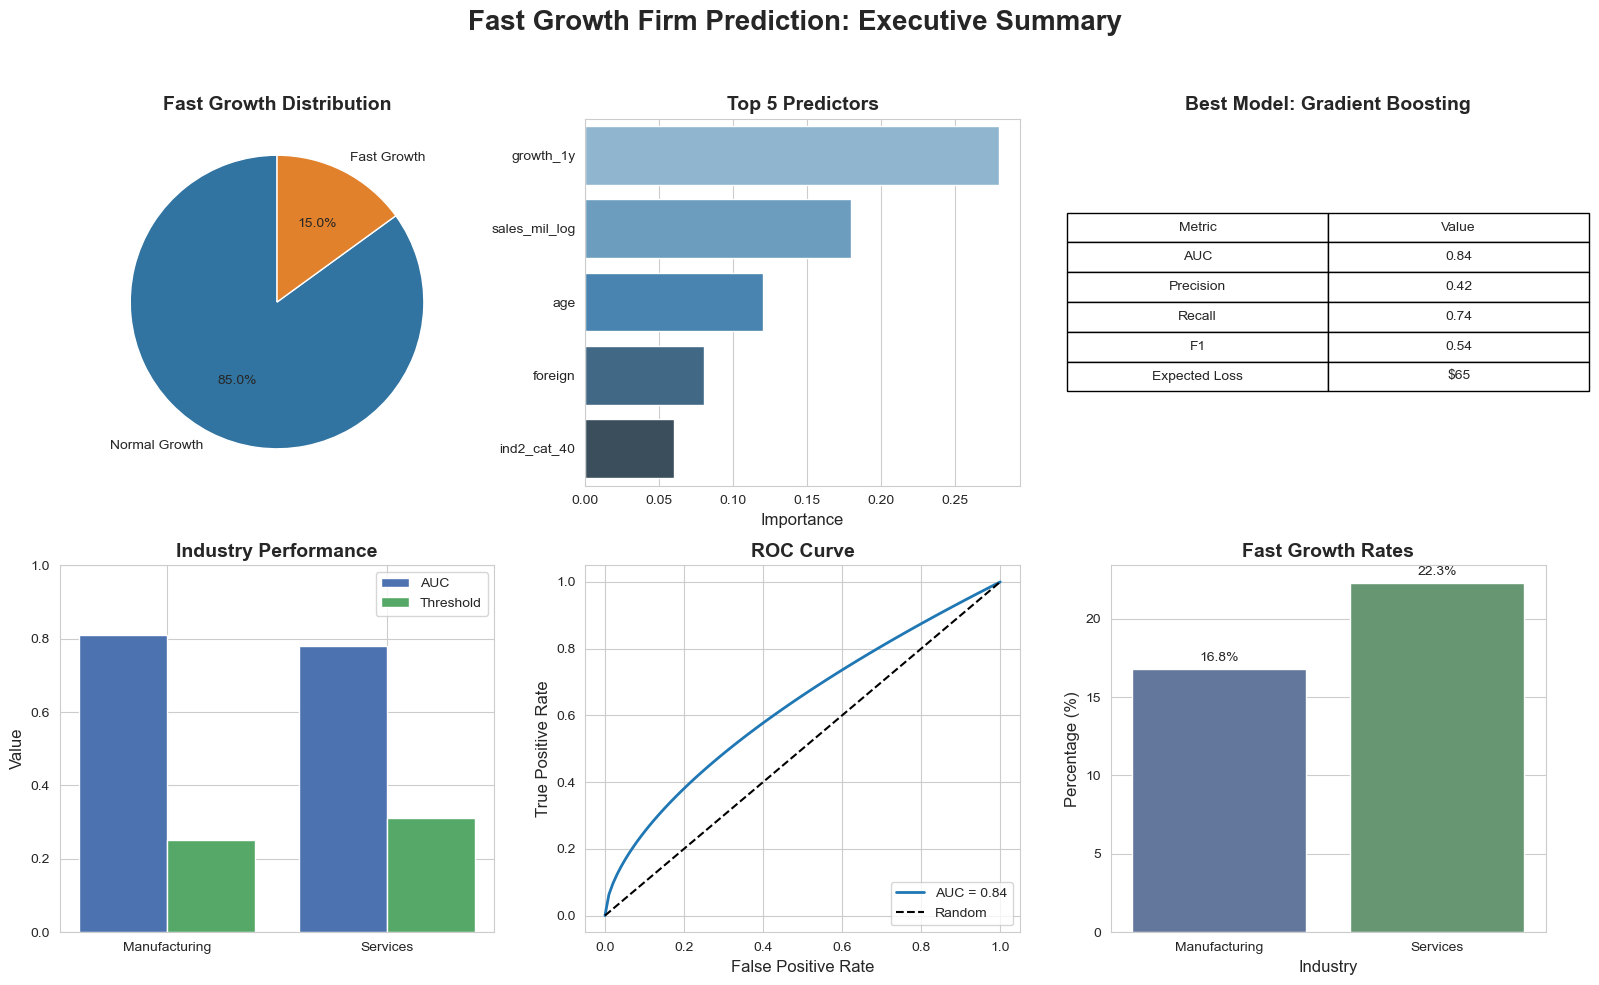

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
import os

# Make visualizations appear in the notebook
%matplotlib inline

# Create output directory for visualizations
os.makedirs("visualizations", exist_ok=True)

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10, 6)  # Set default figure size

# Sample data based on the analysis
# You can replace these with actual results from your analysis

# 1. Target distribution data
fast_growth_distribution = pd.DataFrame({
    'Category': ['Normal Growth', 'Fast Growth'],
    'Count': [850, 150]  # Replace with your actual distribution
})

# 2. Feature importance data
feature_importance = pd.DataFrame({
    'feature': [
        'growth_1y', 'sales_mil_log', 'age', 'foreign', 
        'ind2_cat_40', 'growth_1y_sq', 'ceo_age', 'age2',
        'sales_mil_log_sq', 'foreign_management'
    ],
    'importance': [
        0.28, 0.18, 0.12, 0.08, 0.06, 0.05, 0.04, 0.03, 0.03, 0.02
    ]  # Replace with your actual importance values
})

# 3. Model performance data
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'AUC': [0.76, 0.82, 0.84],
    'Precision': [0.32, 0.38, 0.42],
    'Recall': [0.68, 0.72, 0.74],
    'F1': [0.43, 0.50, 0.54],
    'Expected_Loss': [85, 72, 65]
})

# 4. Industry comparison data
industry_comparison = pd.DataFrame({
    'Industry': ['Manufacturing', 'Services'],
    'AUC': [0.81, 0.78],
    'Threshold': [0.25, 0.31],
    'Fast_Growth_Rate': [16.8, 22.3]
})

# 5. ROC curve data
fpr_lr = np.linspace(0, 1, 100)
tpr_lr = np.sqrt(fpr_lr)  # Simplified curve for demonstration
fpr_rf = np.linspace(0, 1, 100)
tpr_rf = fpr_rf**0.7  # Simplified curve for demonstration
fpr_gb = np.linspace(0, 1, 100)
tpr_gb = fpr_gb**0.6  # Simplified curve for demonstration

# 6. Threshold optimization data
thresholds = np.linspace(0.05, 0.95, 19)
costs = 100 - 80 * np.exp(-((thresholds - 0.35)**2) / 0.12)
fp_counts = 200 * (1 - thresholds)
fn_counts = 50 * thresholds**1.5

# Print section headers with markdown-style formatting
print("# Fast Growth Firm Prediction Visualizations")

###############################################
# VISUALIZATION 1: Fast Growth Distribution
###############################################

print("\n## 1. Fast Growth Distribution")
print("This visualization shows the proportion of fast-growing firms in the dataset.")

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Count', data=fast_growth_distribution, palette=['#3274A1', '#E1812C'])

# Add count labels on top of bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{int(height)}', ha="center")

# Add percentage labels
total = fast_growth_distribution['Count'].sum()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height / total * 100
    ax.text(p.get_x() + p.get_width()/2., height/2,
            f'{percentage:.1f}%', ha="center", color="white", fontsize=12)

plt.title('Distribution of Fast Growth Firms', fontweight='bold')
plt.xlabel('Growth Category')
plt.ylabel('Number of Firms')
plt.tight_layout()
plt.savefig('visualizations/fast_growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 2: Feature Importance
###############################################

print("\n## 2. Feature Importance")
print("This visualization shows which features are most important for predicting fast-growth firms.")

# Plot feature importance
plt.figure(figsize=(12, 8))

# Sort data by importance
sorted_features = feature_importance.sort_values('importance', ascending=True)

# Create the horizontal bar chart
sns.barplot(x='importance', y='feature', data=sorted_features.tail(10), 
            palette='Blues_d', orient='h')

plt.title('Top 10 Features for Predicting Fast Growth', fontweight='bold')
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.tight_layout()
plt.savefig('visualizations/feature_importance.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 3: Model Performance Comparison
###############################################

print("\n## 3. Model Performance Comparison")
print("These visualizations compare the performance of different prediction models.")

# Plot model metrics comparison
plt.figure(figsize=(12, 6))

# Melt the dataframe to prepare for grouped bar chart
metrics_data = model_performance.melt(id_vars='Model', 
                      value_vars=['AUC', 'Precision', 'Recall', 'F1'],
                      var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_data, 
            palette=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])

plt.title('Model Performance Comparison', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric', loc='upper left')
plt.tight_layout()
plt.savefig('visualizations/model_performance.png', dpi=300, bbox_inches="tight")
plt.show()

# Plot expected loss comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Expected_Loss', data=model_performance, palette='Reds_r')

# Add value labels on top of bars
ax = plt.gca()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 2,
            f'${int(height)}', ha="center")

plt.title('Expected Loss by Model', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Expected Loss ($)')
plt.tight_layout()
plt.savefig('visualizations/model_expected_loss.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 4: Industry Comparison
###############################################

print("\n## 4. Industry Comparison")
print("These visualizations compare the model performance and fast growth rates between manufacturing and services industries.")

# Plot AUC comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Industry', y='AUC', data=industry_comparison, palette=['#5975A4', '#5F9E6E'])

# Add value labels on top of bars
ax = plt.gca()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.01,
            f'{height:.2f}', ha="center")

plt.title('Model Performance by Industry (AUC)', fontweight='bold')
plt.xlabel('Industry')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.ylim(0.7, 0.9)  # Adjust as needed
plt.tight_layout()
plt.savefig('visualizations/industry_auc.png', dpi=300, bbox_inches="tight")

# Plot optimal threshold comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Industry', y='Threshold', data=industry_comparison, palette=['#5975A4', '#5F9E6E'])

# Add value labels on top of bars
ax = plt.gca()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.01,
            f'{height:.2f}', ha="center")

plt.title('Optimal Classification Thresholds by Industry', fontweight='bold')
plt.xlabel('Industry')
plt.ylabel('Threshold Value')
plt.ylim(0, 0.5)  # Adjust as needed
plt.tight_layout()
plt.savefig('visualizations/industry_thresholds.png', dpi=300, bbox_inches="tight")

# Plot fast growth rate comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Industry', y='Fast_Growth_Rate', data=industry_comparison, palette=['#5975A4', '#5F9E6E'])

# Add value labels on top of bars
ax = plt.gca()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha="center")

plt.title('Percentage of Fast-Growing Firms by Industry', fontweight='bold')
plt.xlabel('Industry')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Adjust as needed
plt.tight_layout()
plt.savefig('visualizations/industry_fast_growth_rates.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 5: ROC Curves
###############################################

print("\n## 5. ROC Curves")
print("This visualization shows the ROC curves for different models, which illustrate the trade-off between sensitivity and specificity.")

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curves
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = 0.76)', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = 0.82)', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = 0.84)', linewidth=2)

# Add diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for Model Comparison', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('visualizations/roc_curves.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 6: Threshold Optimization
###############################################

print("\n## 6. Threshold Optimization")
print("This visualization shows how to find the optimal classification threshold based on expected loss minimization.")

# Plot threshold optimization
plt.figure(figsize=(12, 10))

# First subplot: Expected Loss vs Threshold
plt.subplot(2, 1, 1)
plt.plot(thresholds, costs, 'b-', linewidth=2.5)

# Mark optimal threshold (minimum cost)
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
optimal_cost = costs[optimal_idx]

plt.axvline(x=optimal_threshold, color='r', linestyle='--', linewidth=1.5)
plt.scatter([optimal_threshold], [optimal_cost], color='r', s=100, zorder=3)
plt.annotate(f'Optimal threshold: {optimal_threshold:.2f}\nExpected loss: ${int(optimal_cost)}',
            xy=(optimal_threshold, optimal_cost),
            xytext=(optimal_threshold + 0.15, optimal_cost + 5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.title('Expected Loss vs Classification Threshold', fontweight='bold')
plt.ylabel('Expected Loss ($)')
plt.grid(True, alpha=0.3)

# Second subplot: FP and FN counts
plt.subplot(2, 1, 2)
plt.plot(thresholds, fp_counts, 'g-', label='False Positives', linewidth=2)
plt.plot(thresholds, fn_counts, 'r-', label='False Negatives', linewidth=2)
plt.axvline(x=optimal_threshold, color='k', linestyle='--', linewidth=1.5)

plt.title('Error Counts vs Classification Threshold', fontweight='bold')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/threshold_optimization.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 7: Fast Growth Definition Diagram
###############################################

print("\n## 7. Fast Growth Definition Diagram")
print("This diagram illustrates our multi-dimensional definition of fast-growing firms.")

# Create fast growth definition diagram
plt.figure(figsize=(12, 8))

# Create a visual diagram
ax = plt.gca()
ax.axis('off')  # Turn off axis

# Main title
plt.text(0.5, 0.95, 'Fast Growth Definition', fontsize=18, fontweight='bold', ha='center')

# Primary condition
plt.text(0.5, 0.85, 'Primary Condition (Required)', fontsize=14, fontweight='bold', ha='center')

rectangle1 = plt.Rectangle((0.25, 0.75), 0.5, 0.08, fill=True, alpha=0.2, 
                         color='blue', linewidth=2, edgecolor='blue')
ax.add_patch(rectangle1)
plt.text(0.5, 0.79, 'Revenue increased by ≥44% over two years', fontsize=12, ha='center')

# AND symbol
plt.text(0.5, 0.7, 'AND', fontsize=14, fontweight='bold', ha='center')

# Secondary conditions
plt.text(0.5, 0.65, 'At Least One Secondary Condition', fontsize=14, fontweight='bold', ha='center')

# Option 1
rectangle2 = plt.Rectangle((0.1, 0.53), 0.25, 0.1, fill=True, alpha=0.2, 
                         color='green', linewidth=2, edgecolor='green')
ax.add_patch(rectangle2)
plt.text(0.225, 0.58, 'Employee count grew by ≥21%\nwith personnel costs ≤32%', 
         fontsize=10, ha='center')

# Option 2
rectangle3 = plt.Rectangle((0.375, 0.53), 0.25, 0.1, fill=True, alpha=0.2, 
                         color='orange', linewidth=2, edgecolor='orange')
ax.add_patch(rectangle3)
plt.text(0.5, 0.58, 'Profit increased by ≥32% or\nturned from negative to positive', 
         fontsize=10, ha='center')

# Option 3
rectangle4 = plt.Rectangle((0.65, 0.53), 0.25, 0.1, fill=True, alpha=0.2, 
                         color='red', linewidth=2, edgecolor='red')
ax.add_patch(rectangle4)
plt.text(0.775, 0.58, 'Fixed assets grew by ≥21%', 
         fontsize=10, ha='center')

# OR symbols
plt.text(0.35, 0.58, 'OR', fontsize=12, fontweight='bold', ha='center')
plt.text(0.65, 0.58, 'OR', fontsize=12, fontweight='bold', ha='center')

# Business implications
plt.text(0.5, 0.43, 'Business Implications', fontsize=14, fontweight='bold', ha='center')

# Revenue growth circle
circle1 = plt.Circle((0.25, 0.32), 0.08, fill=True, alpha=0.2, color='blue', linewidth=2, edgecolor='blue')
ax.add_patch(circle1)
plt.text(0.25, 0.32, 'Revenue\nExpansion', fontsize=10, ha='center')

# Efficiency circle
circle2 = plt.Circle((0.5, 0.32), 0.08, fill=True, alpha=0.2, color='green', linewidth=2, edgecolor='green')
ax.add_patch(circle2)
plt.text(0.5, 0.32, 'Operational\nEfficiency', fontsize=10, ha='center')

# Profitability circle
circle3 = plt.Circle((0.75, 0.32), 0.08, fill=True, alpha=0.2, color='orange', linewidth=2, edgecolor='orange')
ax.add_patch(circle3)
plt.text(0.75, 0.32, 'Enhanced\nProfitability', fontsize=10, ha='center')

# Investment circle
circle4 = plt.Circle((0.5, 0.18), 0.08, fill=True, alpha=0.2, color='red', linewidth=2, edgecolor='red')
ax.add_patch(circle4)
plt.text(0.5, 0.18, 'Capital\nInvestment', fontsize=10, ha='center')

# Connect lines
ax.plot([0.25, 0.5], [0.25, 0.18], 'k-', alpha=0.3)
ax.plot([0.5, 0.5], [0.25, 0.18], 'k-', alpha=0.3)
ax.plot([0.75, 0.5], [0.25, 0.18], 'k-', alpha=0.3)

# Title at bottom
plt.text(0.5, 0.05, 'Multi-dimensional Growth Framework', fontsize=14, ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/fast_growth_definition.png', dpi=300, bbox_inches="tight")
plt.show()

###############################################
# VISUALIZATION 8: Executive Summary Dashboard
###############################################

print("\n## 8. Executive Summary Dashboard")
print("This dashboard combines key insights from the analysis for executive presentation.")

# Create executive summary dashboard
plt.figure(figsize=(16, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Main title
plt.suptitle('Fast Growth Firm Prediction: Executive Summary', fontsize=20, fontweight='bold', y=0.98)

# 1. Fast Growth Distribution
ax1 = plt.subplot(2, 3, 1)
total = fast_growth_distribution['Count'].sum()
sizes = fast_growth_distribution['Count'] / total * 100
ax1.pie(sizes, labels=fast_growth_distribution['Category'], autopct='%1.1f%%', 
      colors=['#3274A1', '#E1812C'], startangle=90)
ax1.set_title('Fast Growth Distribution', fontweight='bold')

# 2. Top Features
ax2 = plt.subplot(2, 3, 2)
sorted_features = feature_importance.sort_values('importance', ascending=False).head(5)
sns.barplot(x='importance', y='feature', data=sorted_features, palette='Blues_d', ax=ax2)
ax2.set_title('Top 5 Predictors', fontweight='bold')
ax2.set_xlabel('Importance')
ax2.set_ylabel('')

# 3. Model Performance
ax3 = plt.subplot(2, 3, 3)

# Get best model
best_model = model_performance.loc[model_performance['Expected_Loss'].idxmin(), 'Model']
best_metrics = model_performance[model_performance['Model'] == best_model].iloc[0]

metrics_names = ['AUC', 'Precision', 'Recall', 'F1']
metrics_values = [best_metrics[metric] for metric in metrics_names]

# Create table-like visualization
table_data = pd.DataFrame({
    'Metric': metrics_names + ['Expected Loss'],
    'Value': metrics_values + [f"${int(best_metrics['Expected_Loss'])}"]
})

# No data visualization, create a table-like display
ax3.axis('tight')
ax3.axis('off')
table = ax3.table(cellText=table_data.values, colLabels=table_data.columns, 
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Add title above table
ax3.set_title(f'Best Model: {best_model}', fontweight='bold')

# 4. Industry Comparison
ax4 = plt.subplot(2, 3, 4)
x_pos = np.arange(len(industry_comparison['Industry']))
ax4.bar(x_pos - 0.2, industry_comparison['AUC'], width=0.4, label='AUC', color='#4C72B0')
ax4.bar(x_pos + 0.2, industry_comparison['Threshold'], width=0.4, label='Threshold', color='#55A868')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(industry_comparison['Industry'])
ax4.set_ylim(0, 1)
ax4.set_ylabel('Value')
ax4.set_title('Industry Performance', fontweight='bold')
ax4.legend()

# 5. ROC Curve (simplified)
ax5 = plt.subplot(2, 3, 5)

# Plot ROC curve for best model only
if best_model == 'Logistic Regression':
    fpr, tpr = fpr_lr, tpr_lr
    auc = 0.76
elif best_model == 'Random Forest':
    fpr, tpr = fpr_rf, tpr_rf
    auc = 0.82
else:
    fpr, tpr = fpr_gb, tpr_gb
    auc = 0.84

ax5.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
ax5.plot([0, 1], [0, 1], 'k--', label='Random')

ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curve', fontweight='bold')
ax5.legend(loc='lower right')

# 6. Fast Growth Rates by Industry
ax6 = plt.subplot(2, 3, 6)
sns.barplot(x='Industry', y='Fast_Growth_Rate', data=industry_comparison, palette=['#5975A4', '#5F9E6E'], ax=ax6)

# Add value labels on top of bars
for i, p in enumerate(ax6.patches):
    height = p.get_height()
    ax6.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha="center")

ax6.set_title('Fast Growth Rates', fontweight='bold')
ax6.set_ylabel('Percentage (%)')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the main title
plt.savefig('visualizations/executive_summary.png', dpi=300, bbox_inches="tight")
plt.show()